<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/simulation/Fed_4_mnist_Emissions_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# basic

## Installations

In [5]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

In [6]:
!pip install codecarbon

In [7]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad, FedAvgM, FedProx, FedAdam, FedYogi

from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context

import os
import pickle
from typing import Callable, Dict, Optional


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.13.1 / PyTorch 2.5.1+cu121


In [8]:
from codecarbon import EmissionsTracker

## Dataloader

In [9]:
BATCH_SIZE = 32

In [10]:
def load_datasets(partition_id: int, num_partitions: int):

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": num_partitions}
    )

    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition = fds.load_partition(partition_id)
    # Divider : 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    #Apply Tranforms
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

### Histogram of the dataset


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

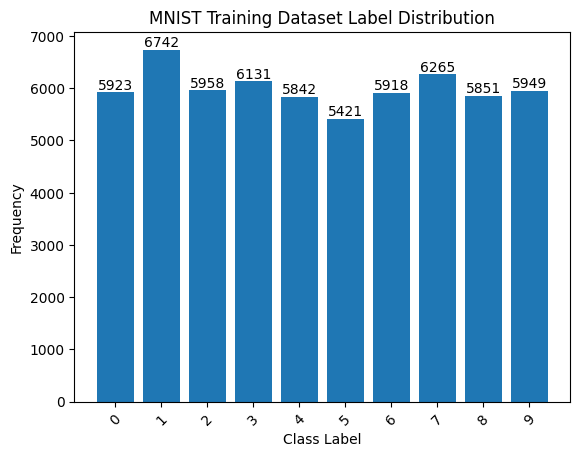

In [11]:
# Load the MNIST dataset
mnist = load_dataset("mnist")

# Construct histogram for training labels
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values())
_ = plt.bar_label(bar)

# Plot formatting
plt.xticks(range(10), labels=[str(i) for i in range(10)], rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("MNIST Training Dataset Label Distribution")
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


One Partition has 6000 examples.
One Partition has 4800 examples.
Entropy: 3.3182
Max Entropy (Uniform Distribution): 3.3219
Distribution Uniformity Ratio: 0.9989


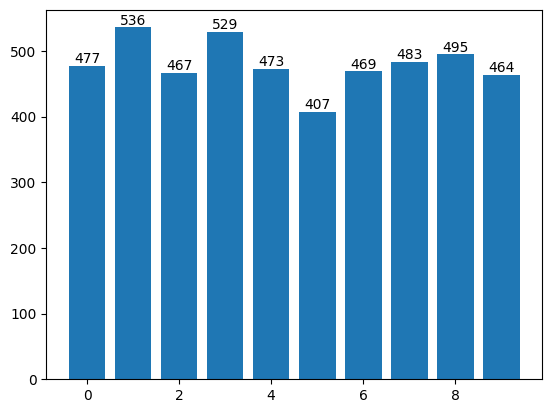

In [12]:
num_partitions = 10  # Total number of participants
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": num_partitions}
)

partition = fds.load_partition(0)
print(f"One Partition has {len(partition)} examples.")

# Divider : 80% train, 20% test
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
train_size = len(partition_train_test["train"])
print(f"One Partition has {train_size} examples.")

all_labels = partition_train_test["train"]["label"]

label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(label_counts.keys(), label_counts.values())
_ = plt.bar_label(bar)

total_count = sum(label_counts.values())

# Calculate proportions
proportions = [count / total_count for count in label_counts.values()]

# Calculate entropy
entropy = -sum(p * np.log2(p) for p in proportions)
max_entropy = np.log2(len(label_counts))  # Maximum entropy for uniform distribution

print(f"Entropy: {entropy:.4f}")
print(f"Max Entropy (Uniform Distribution): {max_entropy:.4f}")
print(f"Distribution Uniformity Ratio: {entropy / max_entropy:.4f}")

so the data is IID

## Model

In [13]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def reset(self):
        """Reset the model's weights to their initial state."""
        for layer in self.children():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                layer.reset_parameters()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


## Train Test func


In [15]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Federation

## Client side

### set-get params


In [24]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

### FlowerClient

In [25]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")

        set_parameters(self.net, parameters)
        lr = config["learning rate"]
        optim = torch.optim.SGD(self.net.parameters(), lr=lr, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)

        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        # current_round = config["server_round"]
        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)

        return float(loss), len(self.valloader), {"accuracy": float(accuracy), "loss": float(loss)}


### Dyamic Configs

In [26]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,
        "local_epochs": 1 ,
        "learning rate": 0.01,
    }
    return config

In [27]:
def evaluate_config(server_round: int):
    config = {
        "current_round": server_round,
    }
    return config

### Client func

In [28]:
def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Server side

### Agregation Function

In [29]:
Aggregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Aggregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

### Server Evaluate

In [30]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
    save_flag = 0,
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    if save_flag == 1 :
      model_filename = f"server_federated_model_{server_round}.pth"
      torch.save(net.state_dict(), model_filename)
      print(f"Model saved as {model_filename}")

    return loss, {"accuracy": accuracy}


## funcs for Plots

In [31]:
def plot_aggregation_history(aggregation_history):
    """Plot accuracy from Aggregation history."""
    accuracy_values = [d['accuracy'] for d in aggregation_history]
    rounds = list(range(len(accuracy_values)))

    plt.figure(figsize=(8, 6))
    plt.plot(rounds, accuracy_values, marker="o", label="Accuracy", color="tab:blue")

    # Annotate points with values
    for x, y in zip(rounds, accuracy_values):
        plt.text(x, y, f"{y:.2f}", fontsize=9, ha='center', va='bottom')

    plt.title("Cumulative Accuracy over Rounds")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_evaluation_history(evaluation_history):
    """Plot loss and accuracy from Evaluation history."""
    rounds = [entry["round"] for entry in evaluation_history]
    loss = [entry["loss"] for entry in evaluation_history]
    accuracy = [entry["accuracy"] for entry in evaluation_history]

    fig, ax1 = plt.subplots(figsize=(8, 6))

    # Plot loss on the first y-axis
    ax1.set_xlabel("Round")
    ax1.set_ylabel("Loss", color="tab:red")
    ax1.plot(rounds, loss, marker="o", color="tab:red", label="Loss")
    ax1.tick_params(axis="y", labelcolor="tab:red")

    # Annotate loss points
    for x, y in zip(rounds, loss):
        ax1.annotate(f"{y:.2f}", (x, y), fontsize=9, color="tab:red", ha='center', va='bottom')

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy", color="tab:blue")
    ax2.plot(rounds, accuracy, marker="o", color="tab:blue", label="Accuracy")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    # Annotate accuracy points
    for x, y in zip(rounds, accuracy):
        ax2.annotate(f"{y:.2f}", (x, y), fontsize=9, color="tab:blue", ha='center', va='bottom')

    # Title and legend
    fig.suptitle("Server Loss and Accuracy over Training Rounds")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")

    plt.show()


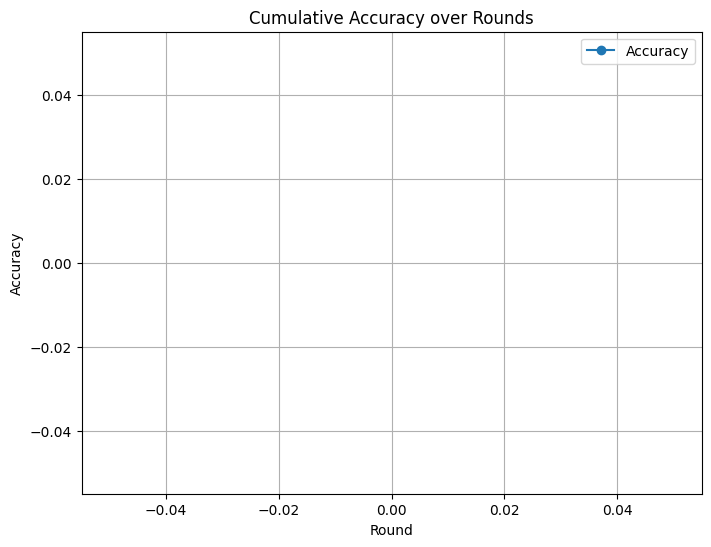

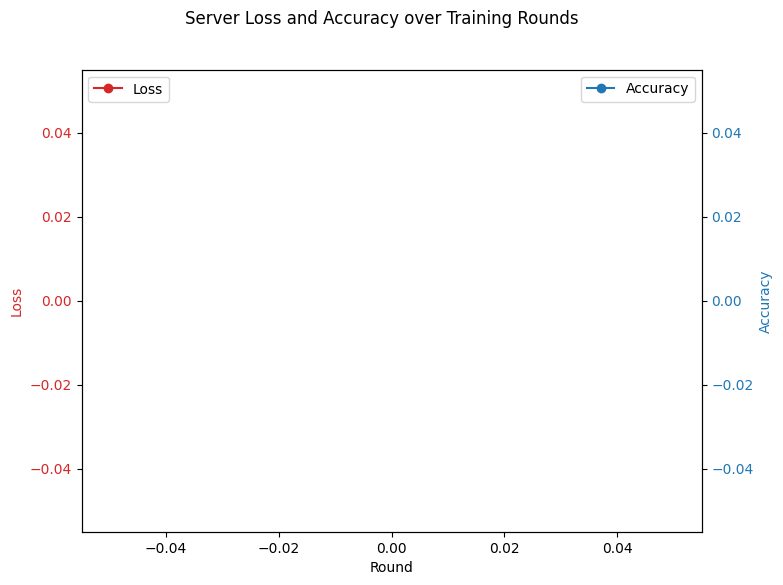

In [32]:
plot_aggregation_history(Aggregation_history)
plot_evaluation_history(evaluation_history)

## My Run Function

In [43]:
def save_results(directory: str, net, aggregation_history, evaluation_history, emissions: float):
    """Save model, history, and emissions data to specified directory."""
    os.makedirs(directory, exist_ok=True)

    # Save the model
    save_path = os.path.join(directory, "net_weights.pth")
    torch.save(net.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    # Save the aggregation history
    agg_history_path = os.path.join(directory, "Aggregation_history.pkl")
    with open(agg_history_path, 'wb') as agg_file:
        pickle.dump(aggregation_history, agg_file)
        print(f"Aggregation history saved to {agg_history_path}")

    # Save the evaluation history
    eval_history_path = os.path.join(directory, "evaluation_history.pkl")
    with open(eval_history_path, 'wb') as eval_file:
        pickle.dump(evaluation_history, eval_file)
        print(f"Evaluation history saved to {eval_history_path}")

    # Save the emissions data
    emissions_path = os.path.join(directory, "emissions.txt")
    with open(emissions_path, 'w') as emissions_file:
        emissions_file.write(f"Total emissions: {emissions} kg CO2e\n")
        print(f"Emissions data saved to {emissions_path}")

def run_my_sim(
    strategy,
    num_rounds: int,
    num_clients: int,
    save_results_flag: bool = True,
    run_simulation_flag: bool = True,
    save_dir: Optional[str] = None,
):
    """Run a federated learning simulation with the given parameters."""
    # Reset the model
    net.reset()
    _, valloader, _ = load_datasets(0, 1)
    _, accuracy = test(net, valloader)
    print(f"model is reset.. dont beleve me?.. acc= {accuracy} ")

    # Initialize client and server apps
    client = ClientApp(client_fn=client_fn)
    params = get_parameters(Net())

    def server_fn(context: Context) -> ServerAppComponents:
        config = ServerConfig(num_rounds=num_rounds)
        print(type(strategy).__name__)
        return ServerAppComponents(strategy=strategy, config=config)

    server = ServerApp(server_fn=server_fn)

    # Initialize history lists
    Aggregation_history.clear()
    evaluation_history.clear()

    # Backend configuration
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

    # ========EmissionsTracker===============
    tracker = EmissionsTracker()
    tracker.start()
    # =======================================

    # Run the simulation if the flag is enabled
    if run_simulation_flag:
        run_simulation(
            server_app=server,
            client_app=client,
            num_supernodes=num_clients,
            backend_config=backend_config,
        )

    # ========EmissionsTracker===============
    emissions: float = tracker.stop()
    print(f"Emissions: {emissions} kg CO2e")
    # =======================================

    # Save results if the flag is enabled
    if save_results_flag:
        strategy_name = type(strategy).__name__
        save_dir = save_dir or strategy_name  # Use provided directory or strategy name
        save_results(save_dir, net, Aggregation_history, evaluation_history, emissions)

    plot_aggregation_history(Aggregation_history)
    plot_evaluation_history(evaluation_history)


### emmision tracker

In [34]:
tracker = EmissionsTracker()
tracker.start()

[codecarbon INFO @ 21:07:22] [setup] RAM Tracking...
[codecarbon INFO @ 21:07:22] [setup] GPU Tracking...
[codecarbon INFO @ 21:07:22] No GPU found.
[codecarbon INFO @ 21:07:22] [setup] CPU Tracking...
[codecarbon WARNING @ 21:07:22] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 21:07:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:07:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:07:24] >>> Tracker's metadata:
[codecarbon INFO @ 21:07:24]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:07:24]   Python version: 3.10.12
[codecarbon INFO @ 21:07:24]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 21:07:24]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:07:24]   CPU count: 2
[codecarbon INFO @ 21:07

In [35]:
emissions: float = tracker.stop()
print(f"Emissions: {emissions} kg CO2e")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[codecarbon INFO @ 21:07:24] Energy consumed for RAM : 0.000000 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:07:24] Energy consumed for all CPUs : 0.000000 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:24] 0.000000 kWh of electricity used since the beginning.
/usr/local/lib/python3.10/dist-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat 

Emissions: 2.482119766376824e-08 kg CO2e


# <!-- This is an invisible comment -->

In [36]:
Num_rounds = 10
NUM_CLIENTS = 10
params = get_parameters(Net())

# Strategies

## FedAvg

In [37]:
strategy = FedAvg(
    fraction_fit  = 1,
    fraction_evaluate = 1,
    min_fit_clients  =  5,
    min_evaluate_clients  = 2,
    min_available_clients = NUM_CLIENTS, # use all
    evaluate_fn = My_evaluate, # function used for validation dy server
    on_fit_config_fn  = fit_config,  # Pass the fit_config function
    on_evaluate_config_fn = evaluate_config,
    # accept_failures,
    # initial_parameters  = ndarrays_to_parameters(params),
    evaluate_metrics_aggregation_fn =  My_weighted_average,
    # inplace,
)

[codecarbon INFO @ 21:07:28] [setup] RAM Tracking...
[codecarbon INFO @ 21:07:28] [setup] GPU Tracking...
[codecarbon INFO @ 21:07:28] No GPU found.
[codecarbon INFO @ 21:07:28] [setup] CPU Tracking...
[codecarbon WARNING @ 21:07:28] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU

[codecarbon WARNING @ 21:07:29] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:07:29] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:07:29] >>> Tracker's metadata:
[codecarbon INFO @ 21:07:29]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:07:29]   Python version: 3.10.12
[codecarbon INFO @ 21:07:29]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 21:07:29]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:07:29]   CPU count: 2
[codecarbon INFO @ 21:07

FedAvg


[codecarbon INFO @ 21:07:44] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:07:44] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:07:44] 0.000197 kWh of electricity used since the beginning.
(pid=2167) 2024-12-08 21:07:45.398001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=2167) 2024-12-08 21:07:45.436918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=2167) 2024-12-08 21:07:45.453142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=2167) 2024-12-08 21:07:47.731843: W tensorf

(ClientAppActor pid=2169) [Client 1] get_parameters


INFO :      initial parameters (loss, other metrics): 0.07221004178524017, {'accuracy': 0.0699}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07221004178524017 / accuracy 0.0699
(ClientAppActor pid=2169) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:08:14] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:08:14] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:14] 0.000591 kWh of electricity used since the beginning.
(ClientAppActor pid=2167) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=2167) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=2167) see the appropriate new directories, set the environment variable
(ClientAppActor pid=2167) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=2167) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=2167)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


(ClientAppActor pid=2169) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


[codecarbon INFO @ 21:08:29] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:08:29] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:29] 0.000787 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2167) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:08:44] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:08:44] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:44] 0.000984 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.008894328901171684, {'accuracy': 0.9134}, 47.39429766200004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.008894328901171684 / accuracy 0.9134
(ClientAppActor pid=2167) [Client 2] evaluate, config: {'current_round': 1}
(ClientAppActor pid=2169) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:08:59] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:08:59] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:08:59] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 6] evaluate, config: {'current_round': 1} [repeated 4x across cluster]
(ClientAppActor pid=2167) [Client 5] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9100000000000001 0.00960921938965718 
(ClientAppActor pid=2167) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:09:14] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:09:14] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:14] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 8] evaluate, config: {'current_round': 1}
(ClientAppActor pid=2167) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2167) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:09:29] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:09:29] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:29] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:09:29] 0.001820 g.CO2eq/s mean an estimation of 57.40514068678001 kg.CO2eq/year


(ClientAppActor pid=2167) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2167) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:09:44] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:09:44] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:44] 0.001772 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.004187384709902107, {'accuracy': 0.9582}, 104.70698971600007)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.004187384709902107 / accuracy 0.9582
(ClientAppActor pid=2167) [Client 4] evaluate, config: {'current_round': 2}
(ClientAppActor pid=2169) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:09:59] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:09:59] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:09:59] 0.001969 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 7] evaluate, config: {'current_round': 2} [repeated 4x across cluster]
(ClientAppActor pid=2167) [Client 1] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9548333333333334 0.004586078827735036 
(ClientAppActor pid=2167) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:10:14] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:10:14] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:14] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 8] evaluate, config: {'current_round': 2}
(ClientAppActor pid=2169) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2169) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2167) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:10:29] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:10:29] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:29] 0.002362 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:10:44] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:10:44] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:44] 0.002559 kWh of electricity used since the beginning.
INFO :      fit progress: (3, 0.0028929828895721587, {'accuracy': 0.9694}, 163.15679015199999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0028929828895721587 / accuracy 0.9694
(ClientAppActor pid=2167) [Client 4] evaluate, config: {'current_round': 3}
(ClientAppActor pid=2169) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 0] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


[codecarbon INFO @ 21:10:59] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:10:59] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:10:59] 0.002756 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 2] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9677499999999999 0.003282237260408389 
(ClientAppActor pid=2169) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 3] evaluate, config: {'current_round': 3}
(ClientAppActor pid=2167) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:11:14] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:11:14] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:14] 0.002953 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2169) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:11:29] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:11:29] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:29] 0.003149 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:29] 0.001820 g.CO2eq/s mean an estimation of 57.40790460597294 kg.CO2eq/year


(ClientAppActor pid=2169) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:11:44] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:11:44] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:44] 0.003346 kWh of electricity used since the beginning.
INFO :      fit progress: (4, 0.002454468586598523, {'accuracy': 0.9746}, 220.83833712600006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.002454468586598523 / accuracy 0.9746
(ClientAppActor pid=2167) [Client 0] evaluate, config: {'current_round': 4}
(ClientAppActor pid=2167) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2169) [Client 8] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


[codecarbon INFO @ 21:11:59] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:11:59] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:11:59] 0.003543 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 6] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9724166666666666 0.0027858255826286042 
(ClientAppActor pid=2167) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 4] evaluate, config: {'current_round': 4}
(ClientAppActor pid=2169) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:12:14] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:12:14] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:14] 0.003740 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2169) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:12:29] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:12:29] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:29] 0.003937 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.0020877900695893915, {'accuracy': 0.9772}, 275.9483243970001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0020877900695893915 / accuracy 0.9772


[codecarbon INFO @ 21:12:44] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:12:44] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:44] 0.004133 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 0] evaluate, config: {'current_round': 5}
(ClientAppActor pid=2167) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 7] evaluate, config: {'current_round': 5} [repeated 4x across cluster]
(ClientAppActor pid=2169) [Client 2] evaluate, config: {'current_round': 5} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9748333333333334 0.002466799641939967 
(ClientAppActor pid=2169) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:12:59] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:12:59] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:12:59] 0.004330 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2169) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:13:14] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:13:14] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:14] 0.004527 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2169) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:13:29] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:13:29] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:29] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:13:29] 0.001820 g.CO2eq/s mean an estimation of 57.40256157381634 kg.CO2eq/year
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.0018835643276805059, {'accuracy': 0.9794}, 335.369667497)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0018835643276805059 / accuracy 0.9794


[codecarbon INFO @ 21:13:44] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:13:44] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:44] 0.004921 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 1] evaluate, config: {'current_round': 6}
(ClientAppActor pid=2167) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 8] evaluate, config: {'current_round': 6} [repeated 4x across cluster]
(ClientAppActor pid=2169) [Client 4] evaluate, config: {'current_round': 6} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.97775 0.002181729357912749 


[codecarbon INFO @ 21:13:59] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:13:59] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:13:59] 0.005118 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2169) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:14:14] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:14:14] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:14] 0.005315 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2167) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:14:29] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:14:29] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:29] 0.005511 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:14:44] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:14:44] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:44] 0.005708 kWh of electricity used since the beginning.
INFO :      fit progress: (7, 0.0017227745093754492, {'accuracy': 0.9812}, 398.23854481)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0017227745093754492 / accuracy 0.9812
(ClientAppActor pid=2167) [Client 0] evaluate, config: {'current_round': 7}
(ClientAppActor pid=2169) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 6] evaluate, config: {'current_round': 7} [repeated 4x across cluster]
(ClientAppActor pid=2169) [Client 3] evaluate, config: {'current_round': 7} [repeated 4x across cluster]


[codecarbon INFO @ 21:14:59] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:14:59] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:14:59] 0.005905 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9795833333333333 0.002049019376562986 
(ClientAppActor pid=2169) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 7] evaluate, config: {'current_round': 7}
(ClientAppActor pid=2169) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:15:14] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:15:14] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:14] 0.006102 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2169) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:15:29] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:15:29] Energy consumed for all CPUs : 0.005665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:29] 0.006299 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:29] 0.001820 g.CO2eq/s mean an estimation of 57.40469355459639 kg.CO2eq/year


(ClientAppActor pid=2169) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:15:44] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:15:44] Energy consumed for all CPUs : 0.005842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:44] 0.006495 kWh of electricity used since the beginning.
INFO :      fit progress: (8, 0.0016524265970801935, {'accuracy': 0.982}, 458.292185132)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0016524265970801935 / accuracy 0.982
(ClientAppActor pid=2167) [Client 0] evaluate, config: {'current_round': 8}
(ClientAppActor pid=2167) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2167) [Client 6] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


[codecarbon INFO @ 21:15:59] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:15:59] Energy consumed for all CPUs : 0.006019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:15:59] 0.006692 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 9] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9804166666666668 0.001942635244136909 
(ClientAppActor pid=2169) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2169) [Client 5] evaluate, config: {'current_round': 8}
(ClientAppActor pid=2169) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:16:14] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:16:14] Energy consumed for all CPUs : 0.006196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:14] 0.006889 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2169) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:16:29] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:16:29] Energy consumed for all CPUs : 0.006373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:29] 0.007086 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:16:44] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:16:44] Energy consumed for all CPUs : 0.006550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:44] 0.007283 kWh of electricity used since the beginning.
INFO :      fit progress: (9, 0.001565036087023327, {'accuracy': 0.9825}, 520.176338754)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.001565036087023327 / accuracy 0.9825
(ClientAppActor pid=2169) [Client 3] evaluate, config: {'current_round': 9}
(ClientAppActor pid=2167) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2169) [Client 7] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


[codecarbon INFO @ 21:16:59] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:16:59] Energy consumed for all CPUs : 0.006727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:16:59] 0.007479 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 4] evaluate, config: {'current_round': 9} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9806666666666666 0.0018592753159149048 
(ClientAppActor pid=2169) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2169) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:17:14] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:17:14] Energy consumed for all CPUs : 0.006904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:14] 0.007676 kWh of electricity used since the beginning.


(ClientAppActor pid=2169) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=2169) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:17:29] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:17:29] Energy consumed for all CPUs : 0.007081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:29] 0.007873 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:29] 0.001820 g.CO2eq/s mean an estimation of 57.40542099711925 kg.CO2eq/year


(ClientAppActor pid=2169) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (10, 0.0014874510586785619, {'accuracy': 0.9839}, 575.66898862)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0014874510586785619 / accuracy 0.9839


[codecarbon INFO @ 21:17:44] Energy consumed for RAM : 0.000811 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:17:44] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:44] 0.008070 kWh of electricity used since the beginning.


(ClientAppActor pid=2167) [Client 2] evaluate, config: {'current_round': 10}
(ClientAppActor pid=2167) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=2169) [Client 8] evaluate, config: {'current_round': 10} [repeated 5x across cluster]
(ClientAppActor pid=2167) [Client 0] evaluate, config: {'current_round': 10} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 589.87s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.00960921938965718
INFO :      		round 2: 0.004586078827735036
INFO :      		round 3: 0.003282237260408389
INFO :      		round 4: 0.0027858255826286042
INFO :      		round 5: 0.002466799641939967
INFO :      		round 6: 0.002181729357912749
INFO :      		round 7: 0.002049019376562986
INFO :      		round 8: 0.001942635244136909
INFO :      		round 9: 0.0018592753159149048
INFO :      		round 10: 0.0017205822847851475
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07221004178524017
INFO :      		round 1: 0.008894328901171684
INFO :      		round 2: 0.004187384709902107
INFO :      		round 3: 0.0028929828895721587
INFO :      		round 4: 0.002454468586598523
INFO :      		round 5: 0.0020877900695893915
INFO :      		round 6: 0.0018835643276805059
INFO :      	

My_weighted_average -0.9819999999999999 0.0017205822847851475 
(ClientAppActor pid=2169) [Client 6] evaluate, config: {'current_round': 10}


[codecarbon INFO @ 21:17:59] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:17:59] Energy consumed for all CPUs : 0.007436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:17:59] 0.008267 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:18:00] Energy consumed for RAM : 0.000832 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:18:00] Energy consumed for all CPUs : 0.007439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:18:00] 0.008271 kWh of electricity used since the beginning.


Emissions: 0.0011475320010216985 kg CO2e
Model saved to FedAvg/net_weights.pth
Aggregation history saved to FedAvg/Aggregation_history.pkl
Evaluation history saved to FedAvg/evaluation_history.pkl
Emissions data saved to FedAvg/emissions.txt


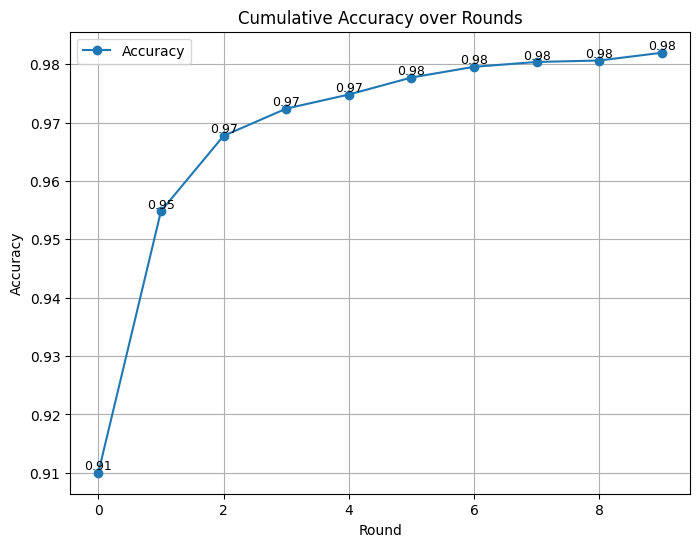

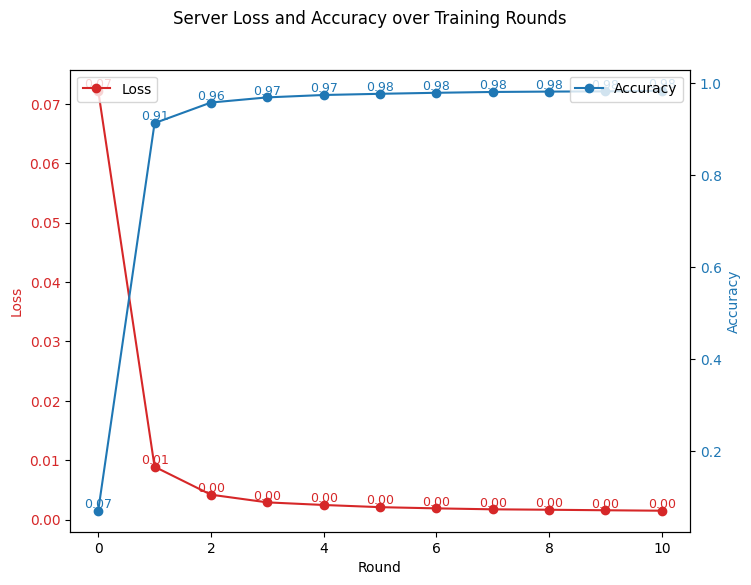

In [38]:
run_my_sim(
    strategy = strategy,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)

## FedAvgM

In [44]:
strategy_1 = FedAvgM(
    fraction_fit  = 1,
    fraction_evaluate = 1,
    min_fit_clients  =  5,
    min_evaluate_clients  = 2,
    min_available_clients = NUM_CLIENTS, # use all
    evaluate_fn = My_evaluate, # function used for validation dy server
    on_fit_config_fn  = fit_config,  # Pass the fit_config function
    on_evaluate_config_fn = evaluate_config,
    # accept_failures,
    initial_parameters  = ndarrays_to_parameters(params),
    server_learning_rate=0.01,  # Learning rate for the server-side update
    server_momentum=0.9  # Momentum for smoothing the server-side updates
)

### RUN


[codecarbon INFO @ 21:37:59] [setup] RAM Tracking...
[codecarbon INFO @ 21:37:59] [setup] GPU Tracking...
[codecarbon INFO @ 21:37:59] No GPU found.
[codecarbon INFO @ 21:37:59] [setup] CPU Tracking...
[codecarbon WARNING @ 21:37:59] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.09791666666666667 


[codecarbon WARNING @ 21:38:01] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:38:01] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:38:01] >>> Tracker's metadata:
[codecarbon INFO @ 21:38:01]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:38:01]   Python version: 3.10.12
[codecarbon INFO @ 21:38:01]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 21:38:01]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:38:01]   CPU count: 2
[codecarbon INFO @ 21:38:01]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:38:01]   GPU count: None
[codecarbon INFO @ 21:38:01]   GPU model: None
[codecarbon INFO @ 21:38:01] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strateg

FedAvgM


INFO :      initial parameters (loss, other metrics): 0.07202895328998565, {'accuracy': 0.1032}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07202895328998565 / accuracy 0.1032


[codecarbon INFO @ 21:38:16] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:38:16] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:16] 0.000197 kWh of electricity used since the beginning.
(pid=11643) 2024-12-08 21:38:19.571550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=11643) 2024-12-08 21:38:19.625032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=11643) 2024-12-08 21:38:19.644090: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=11643) 2024-12-08 21:38:22.244205: W ten

(ClientAppActor pid=11643) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:38:46] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:38:46] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:38:46] 0.000591 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11643) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:39:01] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:39:01] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:01] 0.000787 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:39:16] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:39:16] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:16] 0.000984 kWh of electricity used since the beginning.
INFO :      fit progress: (1, 0.07194814467430115, {'accuracy': 0.1032}, 66.12055892900025)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07194814467430115 / accuracy 0.1032
(ClientAppActor pid=11643) [Client 1] evaluate, config: {'current_round': 1}
(ClientAppActor pid=11643) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11643) [Client 7] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


[codecarbon INFO @ 21:39:31] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:39:31] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:31] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 8] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11642) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11642) [Client 0] evaluate, config: {'current_round': 1}
(ClientAppActor pid=11642) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:39:46] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:39:46] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:39:46] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11643) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:40:01] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:40:01] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:01] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:40:01] 0.001820 g.CO2eq/s mean an estimation of 57.40964158621592 kg.CO2eq/year


(ClientAppActor pid=11643) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:40:16] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:40:16] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:16] 0.001772 kWh of electricity used since the beginning.
INFO :      fit progress: (2, 0.07176279969215393, {'accuracy': 0.1032}, 126.73083229299982)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07176279969215393 / accuracy 0.1032
(ClientAppActor pid=11642) [Client 1] evaluate, config: {'current_round': 2}
(ClientAppActor pid=11642) [Client 8, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11642) [Client 7] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


[codecarbon INFO @ 21:40:31] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:40:31] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:31] 0.001968 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 9] evaluate, config: {'current_round': 2} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11642) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:40:46] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:40:46] Energy consumed for all CPUs : 0.001947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:46] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:41:01] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:41:01] Energy consumed for all CPUs : 0.002124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:01] 0.002362 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 0, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:41:16] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:41:16] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:16] 0.002559 kWh of electricity used since the beginning.
INFO :      fit progress: (3, 0.07142107384204864, {'accuracy': 0.1032}, 186.78633766700023)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07142107384204864 / accuracy 0.1032
(ClientAppActor pid=11642) [Client 1] evaluate, config: {'current_round': 3}
(ClientAppActor pid=11643) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11642) [Client 8] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


[codecarbon INFO @ 21:41:31] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:41:31] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:31] 0.002756 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 3] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11643) [Client 1, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:41:46] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:41:46] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:41:46] 0.002953 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 2] evaluate, config: {'current_round': 3}
(ClientAppActor pid=11643) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11643) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:42:01] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:42:01] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:01] 0.003149 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:42:01] 0.001821 g.CO2eq/s mean an estimation of 57.4125831973269 kg.CO2eq/year


(ClientAppActor pid=11643) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11643) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:42:16] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:42:16] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:16] 0.003346 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.07084286291599273, {'accuracy': 0.1053}, 250.25167376399986)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07084286291599273 / accuracy 0.1053
(ClientAppActor pid=11642) [Client 2] evaluate, config: {'current_round': 4}
(ClientAppActor pid=11642) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:42:31] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:42:31] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:31] 0.003543 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 8] evaluate, config: {'current_round': 4} [repeated 4x across cluster]
(ClientAppActor pid=11642) [Client 7] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11642) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:42:46] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:42:46] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:42:46] 0.003740 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 9] evaluate, config: {'current_round': 4}
(ClientAppActor pid=11642) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 5, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:43:01] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:43:01] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:01] 0.003937 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:43:16] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:43:16] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:16] 0.004133 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.06992387049198151, {'accuracy': 0.1342}, 310.6294260039999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06992387049198151 / accuracy 0.1342
(ClientAppActor pid=11643) [Client 0] evaluate, config: {'current_round': 5}
(ClientAppActor pid=11643) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:43:31] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:43:31] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:31] 0.004330 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 8] evaluate, config: {'current_round': 5} [repeated 4x across cluster]
(ClientAppActor pid=11643) [Client 1] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11642) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:43:46] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:43:46] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:43:46] 0.004527 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 6] evaluate, config: {'current_round': 5}
(ClientAppActor pid=11642) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:44:01] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:44:01] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:01] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:44:01] 0.001820 g.CO2eq/s mean an estimation of 57.40449939296877 kg.CO2eq/year


(ClientAppActor pid=11642) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:44:16] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:44:16] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:16] 0.004921 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.06853561856746673, {'accuracy': 0.23}, 373.4697476189999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06853561856746673 / accuracy 0.23
(ClientAppActor pid=11643) [Client 0] evaluate, config: {'current_round': 6}
(ClientAppActor pid=11643) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:44:31] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:44:31] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:31] 0.005118 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 7] evaluate, config: {'current_round': 6} [repeated 4x across cluster]
(ClientAppActor pid=11643) [Client 9] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11643) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:44:46] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:44:46] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:44:46] 0.005315 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 1] evaluate, config: {'current_round': 6}
(ClientAppActor pid=11643) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11643) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:45:01] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:45:01] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:01] 0.005512 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 1, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11643) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:45:16] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:45:16] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:16] 0.005708 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.06654708728790283, {'accuracy': 0.4832}, 434.28334957100014)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06654708728790283 / accuracy 0.4832


[codecarbon INFO @ 21:45:31] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:45:31] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:31] 0.005905 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 3] evaluate, config: {'current_round': 7}
(ClientAppActor pid=11642) [Client 9, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11642) [Client 7] evaluate, config: {'current_round': 7} [repeated 4x across cluster]
(ClientAppActor pid=11642) [Client 4] evaluate, config: {'current_round': 7} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11643) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:45:46] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:45:46] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:45:46] 0.006102 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 8] evaluate, config: {'current_round': 7}
(ClientAppActor pid=11642) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:46:01] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:46:01] Energy consumed for all CPUs : 0.005665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:01] 0.006299 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:46:01] 0.001820 g.CO2eq/s mean an estimation of 57.403095460440426 kg.CO2eq/year


(ClientAppActor pid=11642) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:46:16] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:46:16] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:16] 0.006496 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.06381885628700257, {'accuracy': 0.6981}, 496.08638033399984)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06381885628700257 / accuracy 0.6981


[codecarbon INFO @ 21:46:31] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:46:31] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:31] 0.006693 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 0] evaluate, config: {'current_round': 8}
(ClientAppActor pid=11643) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11643) [Client 8] evaluate, config: {'current_round': 8} [repeated 4x across cluster]
(ClientAppActor pid=11643) [Client 1] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
[codecarbon INFO @ 21:46:46] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:46:46] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:46:46] 0.006889 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11642) [Client 7] evaluate, config: {'current_round': 8}
(ClientAppActor pid=11642) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:47:01] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:47:01] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:01] 0.007086 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11643) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:47:16] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:47:16] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:16] 0.007283 kWh of electricity used since the beginning.


(ClientAppActor pid=11643) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:47:31] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:47:31] Energy consumed for all CPUs : 0.006728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:31] 0.007480 kWh of electricity used since the beginning.
INFO :      fit progress: (9, 0.060229129135608676, {'accuracy': 0.8317}, 559.4499859480002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.060229129135608676 / accuracy 0.8317
(ClientAppActor pid=11643) [Client 2] evaluate, config: {'current_round': 9}
(ClientAppActor pid=11642) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11642) [Client 8] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


[codecarbon INFO @ 21:47:46] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:47:46] Energy consumed for all CPUs : 0.006905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:47:46] 0.007677 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 4] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11642) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11643) [Client 1] evaluate, config: {'current_round': 9}
(ClientAppActor pid=11642) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:48:01] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:48:01] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:01] 0.007874 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:48:01] 0.001820 g.CO2eq/s mean an estimation of 57.41115248788355 kg.CO2eq/year


(ClientAppActor pid=11642) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:48:16] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:48:16] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:16] 0.008071 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=11642) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:48:31] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:48:31] Energy consumed for all CPUs : 0.007436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:31] 0.008268 kWh of electricity used since the beginning.
INFO :      fit progress: (10, 0.05570323873758316, {'accuracy': 0.888}, 622.0693094580001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.05570323873758316 / accuracy 0.888
(ClientAppActor pid=11643) [Client 0] evaluate, config: {'current_round': 10}
(ClientAppActor pid=11643) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=11643) [Client 6] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


[codecarbon INFO @ 21:48:46] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:48:46] Energy consumed for all CPUs : 0.007613 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:46] 0.008464 kWh of electricity used since the beginning.


(ClientAppActor pid=11642) [Client 1] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 636.67s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07276063400506974
INFO :      		round 2: 0.07257638136545817
INFO :      		round 3: 0.07223641028006873
INFO :      		round 4: 0.07166135497887931
INFO :      		round 5: 0.07074686566988628
INFO :      		round 6: 0.06936273543039959
INFO :      		round 7: 0.06737904457251231
INFO :      		round 8: 0.06466219158967336
INFO :      		round 9: 0.06109429026643435
INFO :      		round 10: 0.056593796392281855
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07202895328998565
INFO :      		round 1: 0.07194814467430115
INFO :      		round 2: 0.07176279969215393
INFO :      		round 3: 0.07142107384204864
INFO :      		round 4: 0.07084286291599273
INFO :      		round 5: 0.06992387049198151
INFO :      		round 6: 0.06853561856746673
INFO :      		round 7: 0.06654708

(ClientAppActor pid=11643) [Client 3] evaluate, config: {'current_round': 10}


(ClientAppActor pid=11642) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=11642) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=11642) see the appropriate new directories, set the environment variable
(ClientAppActor pid=11642) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=11642) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=11642)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
[codecarbon INFO @ 21:48:54] Energy consumed for RAM : 0.000861 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:48:54] Energy consumed for all CPUs : 0.007701 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:48:54] 0.008562 kWh of electricity used since the beginning.


Emissions: 0.0011879435553344595 kg CO2e
Model saved to FedAvgM/net_weights.pth
Aggregation history saved to FedAvgM/Aggregation_history.pkl
Evaluation history saved to FedAvgM/evaluation_history.pkl
Emissions data saved to FedAvgM/emissions.txt


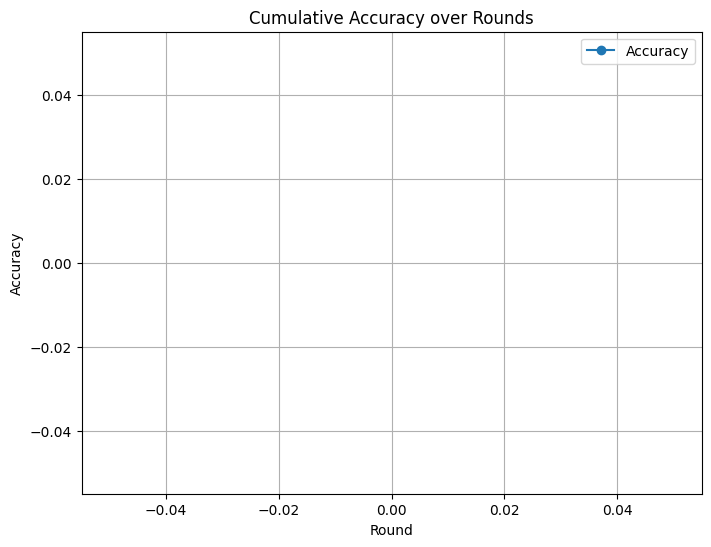

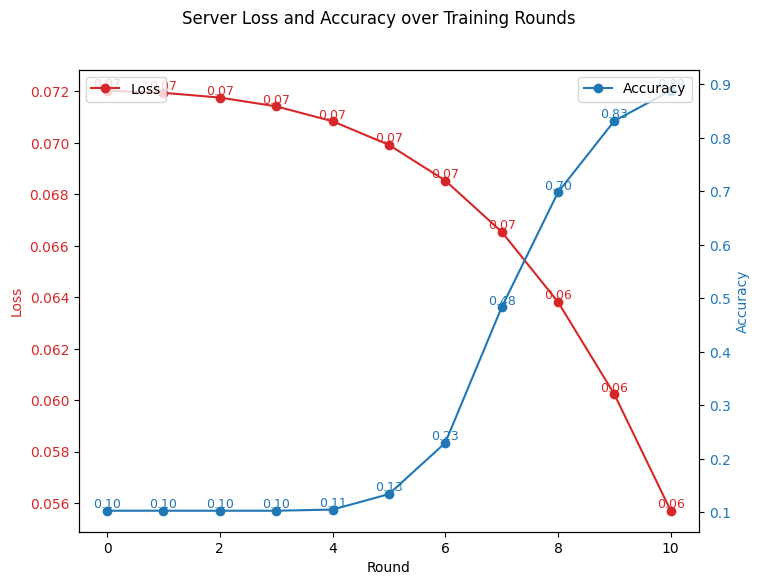

In [45]:
run_my_sim(
    strategy = strategy_1,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)

## FedAdagrad

In [46]:
strategy_2 = FedAdagrad(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        on_evaluate_config_fn = evaluate_config,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        eta=0.0001,
        eta_l=0.001,
        tau=1e-8,
    )

### RUN


[codecarbon INFO @ 21:49:05] [setup] RAM Tracking...
[codecarbon INFO @ 21:49:05] [setup] GPU Tracking...
[codecarbon INFO @ 21:49:05] No GPU found.
[codecarbon INFO @ 21:49:05] [setup] CPU Tracking...
[codecarbon WARNING @ 21:49:05] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.09875 


[codecarbon WARNING @ 21:49:07] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:49:07] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:49:07] >>> Tracker's metadata:
[codecarbon INFO @ 21:49:07]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:49:07]   Python version: 3.10.12
[codecarbon INFO @ 21:49:07]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 21:49:07]   Available RAM : 12.675 GB
[codecarbon INFO @ 21:49:07]   CPU count: 2
[codecarbon INFO @ 21:49:07]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 21:49:07]   GPU count: None
[codecarbon INFO @ 21:49:07]   GPU model: None
[codecarbon INFO @ 21:49:07] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strateg

FedAdagrad


INFO :      initial parameters (loss, other metrics): 0.07202895328998565, {'accuracy': 0.1032}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07202895328998565 / accuracy 0.1032


[codecarbon INFO @ 21:49:22] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:49:22] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:22] 0.000197 kWh of electricity used since the beginning.
(pid=16404) 2024-12-08 21:49:23.462416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16404) 2024-12-08 21:49:23.504381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16404) 2024-12-08 21:49:23.529432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=16403) 2024-12-08 21:49:27.492176: W ten

(ClientAppActor pid=16403) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:49:52] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:49:52] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:49:52] 0.000591 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16403) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:50:07] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:50:07] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:07] 0.000788 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16403) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:50:22] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:50:22] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:22] 0.000984 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.07199942152500152, {'accuracy': 0.1032}, 71.07003226999996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07199942152500152 / accuracy 0.1032
(ClientAppActor pid=16404) [Client 0] evaluate, config: {'current_round': 1}
(ClientAppActor pid=16404) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:50:37] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:50:37] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:37] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 5] evaluate, config: {'current_round': 1} [repeated 4x across cluster]
(ClientAppActor pid=16404) [Client 6] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333332 0.07281152166922887 
(ClientAppActor pid=16403) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:50:52] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:50:52] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:50:52] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 7] evaluate, config: {'current_round': 1}
(ClientAppActor pid=16403) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16403) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:51:07] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:51:07] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:07] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:51:07] 0.001820 g.CO2eq/s mean an estimation of 57.400301383421464 kg.CO2eq/year


(ClientAppActor pid=16403) [Client 2, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:51:22] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:51:22] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:22] 0.001772 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.07197896432876587, {'accuracy': 0.1032}, 134.66279176600028)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07197896432876587 / accuracy 0.1032


[codecarbon INFO @ 21:51:37] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:51:37] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:37] 0.001968 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 4] evaluate, config: {'current_round': 2}
(ClientAppActor pid=16404) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16403) [Client 7] evaluate, config: {'current_round': 2} [repeated 4x across cluster]
(ClientAppActor pid=16404) [Client 8] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.0727911286354065 


[codecarbon INFO @ 21:51:52] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:51:52] Energy consumed for all CPUs : 0.001947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:51:52] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16403) [Client 0] evaluate, config: {'current_round': 2}
(ClientAppActor pid=16403) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:52:07] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:52:07] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:07] 0.002362 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16403) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:52:22] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:52:22] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:22] 0.002559 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 9, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:52:37] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:52:37] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:37] 0.002756 kWh of electricity used since the beginning.
INFO :      fit progress: (3, 0.07196220216751098, {'accuracy': 0.1032}, 196.94537425199997)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07196220216751098 / accuracy 0.1032
(ClientAppActor pid=16404) [Client 3] evaluate, config: {'current_round': 3}
(ClientAppActor pid=16403) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16404) [Client 7] evaluate, config: {'current_round': 3} [repeated 4x across cluster]
(ClientAppActor pid=16404) [Client 2] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


[codecarbon INFO @ 21:52:52] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:52:52] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:52:52] 0.002952 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07277441304922103 
(ClientAppActor pid=16404) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16403) [Client 4] evaluate, config: {'current_round': 3}
(ClientAppActor pid=16404) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:53:07] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:53:07] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:07] 0.003149 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:53:07] 0.001820 g.CO2eq/s mean an estimation of 57.409371064356776 kg.CO2eq/year


(ClientAppActor pid=16404) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16404) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:53:22] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:53:22] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:22] 0.003346 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:53:37] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:53:37] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:37] 0.003543 kWh of electricity used since the beginning.
INFO :      fit progress: (4, 0.07194749643802643, {'accuracy': 0.1032}, 258.76732335700035)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07194749643802643 / accuracy 0.1032
(ClientAppActor pid=16404) [Client 3] evaluate, config: {'current_round': 4}
(ClientAppActor pid=16403) [Client 6, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16404) [Client 8] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


[codecarbon INFO @ 21:53:52] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:53:52] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:53:52] 0.003740 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 6] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07275966854890188 
(ClientAppActor pid=16403) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16403) [Client 2] evaluate, config: {'current_round': 4}
(ClientAppActor pid=16403) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:54:07] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:54:07] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:07] 0.003937 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16403) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:54:22] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:54:22] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:22] 0.004134 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:54:37] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:54:37] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:37] 0.004331 kWh of electricity used since the beginning.
INFO :      fit progress: (5, 0.07193444502353669, {'accuracy': 0.1032}, 316.973697379)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07193444502353669 / accuracy 0.1032
(ClientAppActor pid=16404) [Client 0] evaluate, config: {'current_round': 5}
(ClientAppActor pid=16404) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16403) [Client 7] evaluate, config: {'current_round': 5} [repeated 4x across cluster]
(ClientAppActor pid=16403) [Client 5] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


[codecarbon INFO @ 21:54:52] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:54:52] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:54:52] 0.004527 kWh of electricity used since the beginning.
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333332 0.072746591091156 
(ClientAppActor pid=16404) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16404) [Client 8] evaluate, config: {'current_round': 5}
(ClientAppActor pid=16404) [Client 4, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:55:07] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:55:07] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:07] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:55:07] 0.001820 g.CO2eq/s mean an estimation of 57.405011195469356 kg.CO2eq/year


(ClientAppActor pid=16404) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16404) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:55:22] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:55:22] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:22] 0.004921 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:55:37] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:55:37] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:37] 0.005118 kWh of electricity used since the beginning.
INFO :      fit progress: (6, 0.07192252855300903, {'accuracy': 0.1032}, 380.1233538910001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07192252855300903 / accuracy 0.1032
(ClientAppActor pid=16404) [Client 1] evaluate, config: {'current_round': 6}
(ClientAppActor pid=16403) [Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16404) [Client 7] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


[codecarbon INFO @ 21:55:52] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:55:52] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:55:52] 0.005315 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 2] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333335 0.0727346757054329 
(ClientAppActor pid=16404) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16403) [Client 4] evaluate, config: {'current_round': 6}
(ClientAppActor pid=16404) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:56:07] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:56:07] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:07] 0.005512 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16404) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:56:22] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:56:22] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:22] 0.005708 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:56:37] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:56:37] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:37] 0.005905 kWh of electricity used since the beginning.
INFO :      fit progress: (7, 0.07191118669509888, {'accuracy': 0.1032}, 440.3641978560004)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07191118669509888 / accuracy 0.1032
(ClientAppActor pid=16403) [Client 0] evaluate, config: {'current_round': 7}
(ClientAppActor pid=16403) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16404) [Client 7] evaluate, config: {'current_round': 7} [repeated 4x across cluster]


[codecarbon INFO @ 21:56:52] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:56:52] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:56:52] 0.006102 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 9] evaluate, config: {'current_round': 7} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07272328086694083 
(ClientAppActor pid=16404) [Client 1, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16404) [Client 1] evaluate, config: {'current_round': 7}
(ClientAppActor pid=16403) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:57:07] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:57:07] Energy consumed for all CPUs : 0.005665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:07] 0.006299 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:57:07] 0.001820 g.CO2eq/s mean an estimation of 57.39903557639506 kg.CO2eq/year


(ClientAppActor pid=16404) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16404) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:57:22] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:57:22] Energy consumed for all CPUs : 0.005842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:22] 0.006495 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:57:37] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:57:37] Energy consumed for all CPUs : 0.006019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:37] 0.006692 kWh of electricity used since the beginning.
INFO :      fit progress: (8, 0.07190085282325745, {'accuracy': 0.1032}, 501.050816298)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07190085282325745 / accuracy 0.1032
(ClientAppActor pid=16404) [Client 1] evaluate, config: {'current_round': 8}
(ClientAppActor pid=16403) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16404) [Client 5] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


[codecarbon INFO @ 21:57:52] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:57:52] Energy consumed for all CPUs : 0.006196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:57:52] 0.006889 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 8] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07271284965674082 
(ClientAppActor pid=16404) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16404) [Client 4] evaluate, config: {'current_round': 8}
(ClientAppActor pid=16404) [Client 4, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:58:07] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:58:07] Energy consumed for all CPUs : 0.006373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:07] 0.007086 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16403) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:58:22] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:58:22] Energy consumed for all CPUs : 0.006550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:22] 0.007283 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 21:58:37] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:58:37] Energy consumed for all CPUs : 0.006727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:37] 0.007479 kWh of electricity used since the beginning.
INFO :      fit progress: (9, 0.07189098966121674, {'accuracy': 0.1032}, 562.425341179)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07189098966121674 / accuracy 0.1032
(ClientAppActor pid=16403) [Client 3] evaluate, config: {'current_round': 9}
(ClientAppActor pid=16404) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=16403) [Client 8] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


[codecarbon INFO @ 21:58:52] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:58:52] Energy consumed for all CPUs : 0.006904 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:58:52] 0.007676 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 9] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07270295361677805 
(ClientAppActor pid=16403) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:59:07] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:59:07] Energy consumed for all CPUs : 0.007081 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:07] 0.007873 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:59:07] 0.001820 g.CO2eq/s mean an estimation of 57.40355800817858 kg.CO2eq/year


(ClientAppActor pid=16404) [Client 0] evaluate, config: {'current_round': 9}
(ClientAppActor pid=16403) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16403) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:59:22] Energy consumed for RAM : 0.000811 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:59:22] Energy consumed for all CPUs : 0.007258 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:22] 0.008070 kWh of electricity used since the beginning.


(ClientAppActor pid=16403) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=16403) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 21:59:37] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:59:37] Energy consumed for all CPUs : 0.007435 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:37] 0.008267 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (10, 0.07188181853294373, {'accuracy': 0.1032}, 623.7043185990001)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07188181853294373 / accuracy 0.1032
(ClientAppActor pid=16404) [Client 0] evaluate, config: {'current_round': 10}
(ClientAppActor pid=16404) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 21:59:52] Energy consumed for RAM : 0.000851 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 21:59:52] Energy consumed for all CPUs : 0.007612 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:59:52] 0.008463 kWh of electricity used since the beginning.


(ClientAppActor pid=16404) [Client 6] evaluate, config: {'current_round': 10} [repeated 4x across cluster]
(ClientAppActor pid=16404) [Client 4] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 638.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07281152166922887
INFO :      		round 2: 0.0727911286354065
INFO :      		round 3: 0.07277441304922103
INFO :      		round 4: 0.07275966854890188
INFO :      		round 5: 0.072746591091156
INFO :      		round 6: 0.0727346757054329
INFO :      		round 7: 0.07272328086694083
INFO :      		round 8: 0.07271284965674082
INFO :      		round 9: 0.07270295361677805
INFO :      		round 10: 0.07269372993707657
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07202895328998565
INFO :      		round 1: 0.07199942152500152
INFO :      		round 2: 0.07197896432876587
INFO :      		round 3: 0.07196220216751098
INFO :      		round 4: 0.07194749643802643
INFO :      		round 5: 0.07193444502353669
INFO :      		round 6: 0.07192252855300903
INFO :      		round 7: 0.0719111866950

My_weighted_average -0.10183333333333333 0.07269372993707657 
(ClientAppActor pid=16403) [Client 9] evaluate, config: {'current_round': 10}


(ClientAppActor pid=16403) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=16403) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=16403) see the appropriate new directories, set the environment variable
(ClientAppActor pid=16403) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=16403) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=16403)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
[codecarbon INFO @ 22:00:02] Energy consumed for RAM : 0.000864 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:00:02] Energy consumed for all CPUs : 0.007730 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:02] 0.008594 kWh of electricity used since the beginning.


Emissions: 0.0011924794564448543 kg CO2e
Model saved to FedAdagrad/net_weights.pth
Aggregation history saved to FedAdagrad/Aggregation_history.pkl
Evaluation history saved to FedAdagrad/evaluation_history.pkl
Emissions data saved to FedAdagrad/emissions.txt


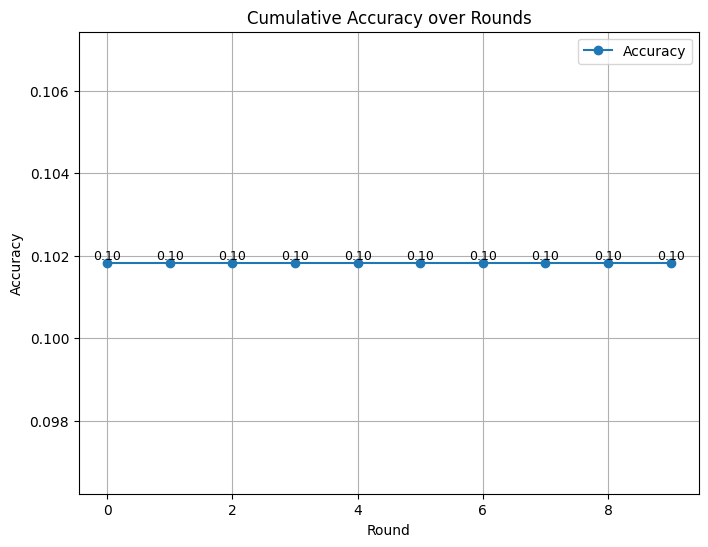

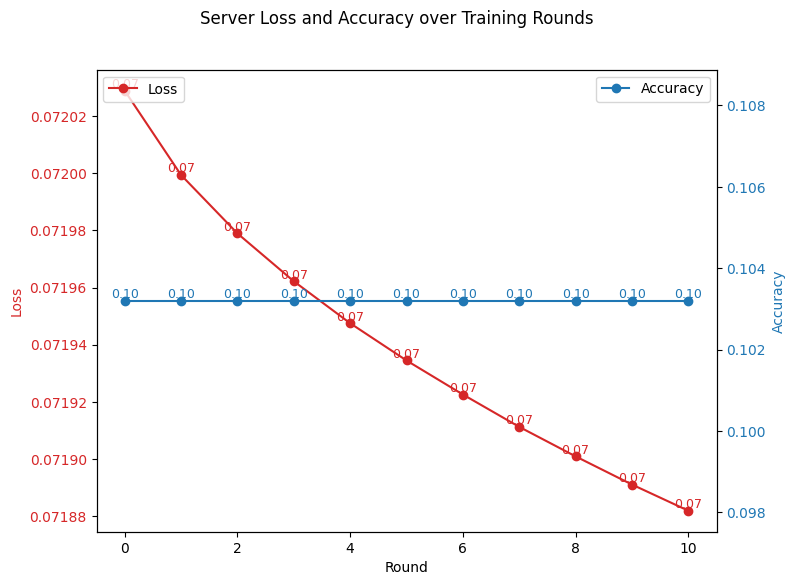

In [47]:
run_my_sim(
    strategy = strategy_2,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)

## FedProx

In [48]:
strategy_3 = FedProx(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        on_evaluate_config_fn = evaluate_config,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        proximal_mu = 0.1
    )

### RUN


[codecarbon INFO @ 22:00:16] [setup] RAM Tracking...
[codecarbon INFO @ 22:00:16] [setup] GPU Tracking...
[codecarbon INFO @ 22:00:16] No GPU found.
[codecarbon INFO @ 22:00:16] [setup] CPU Tracking...
[codecarbon WARNING @ 22:00:16] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.1085 


[codecarbon WARNING @ 22:00:17] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 22:00:17] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 22:00:17] >>> Tracker's metadata:
[codecarbon INFO @ 22:00:17]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 22:00:17]   Python version: 3.10.12
[codecarbon INFO @ 22:00:17]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 22:00:17]   Available RAM : 12.675 GB
[codecarbon INFO @ 22:00:17]   CPU count: 2
[codecarbon INFO @ 22:00:17]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 22:00:17]   GPU count: None
[codecarbon INFO @ 22:00:17]   GPU model: None
[codecarbon INFO @ 22:00:18] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strateg

FedProx


INFO :      initial parameters (loss, other metrics): 0.07202895328998565, {'accuracy': 0.1032}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07202895328998565 / accuracy 0.1032


[codecarbon INFO @ 22:00:33] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:00:33] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:00:33] 0.000197 kWh of electricity used since the beginning.
(pid=21216) 2024-12-08 22:00:34.576747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=21216) 2024-12-08 22:00:34.631544: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=21216) 2024-12-08 22:00:34.648055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=21216) 2024-12-08 22:00:37.193576: W ten

(ClientAppActor pid=21219) [Client 0, round 1] fit, config: {'server_round': 1, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:01:03] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:01:03] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:03] 0.000591 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 3, round 1] fit, config: {'server_round': 1, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 8, round 1] fit, config: {'server_round': 1, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 2, round 1] fit, config: {'server_round': 1, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:01:18] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:01:18] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:18] 0.000788 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 5, round 1] fit, config: {'server_round': 1, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:01:33] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:01:33] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:33] 0.000984 kWh of electricity used since the beginning.
INFO :      fit progress: (1, 0.00814874084368348, {'accuracy': 0.9212}, 69.53047410599993)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.00814874084368348 / accuracy 0.9212
(ClientAppActor pid=21219) [Client 2] evaluate, config: {'current_round': 1}
(ClientAppActor pid=21216) [Client 7, round 1] fit, config: {'server_round': 1, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21219) [Client 6] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


[codecarbon INFO @ 22:01:48] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:01:48] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:01:48] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 1] evaluate, config: {'current_round': 1} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9139166666666667 0.008723807342971367 
(ClientAppActor pid=21216) [Client 0, round 2] fit, config: {'server_round': 2, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21216) [Client 9] evaluate, config: {'current_round': 1}
(ClientAppActor pid=21216) [Client 4, round 2] fit, config: {'server_round': 2, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:02:03] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:02:03] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:03] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 6, round 2] fit, config: {'server_round': 2, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21216) [Client 1, round 2] fit, config: {'server_round': 2, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:02:18] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:02:18] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:18] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:02:18] 0.001820 g.CO2eq/s mean an estimation of 57.40439967347245 kg.CO2eq/year


(ClientAppActor pid=21216) [Client 7, round 2] fit, config: {'server_round': 2, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.004115503194509074, {'accuracy': 0.9603}, 126.09164567900007)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.004115503194509074 / accuracy 0.9603


[codecarbon INFO @ 22:02:33] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:02:33] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:33] 0.001771 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 1] evaluate, config: {'current_round': 2}
(ClientAppActor pid=21219) [Client 8, round 2] fit, config: {'server_round': 2, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21216) [Client 5] evaluate, config: {'current_round': 2} [repeated 4x across cluster]
(ClientAppActor pid=21216) [Client 3] evaluate, config: {'current_round': 2} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9547499999999999 0.004617787312949076 


[codecarbon INFO @ 22:02:48] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:02:48] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:02:48] 0.001968 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 1, round 3] fit, config: {'server_round': 3, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21219) [Client 9] evaluate, config: {'current_round': 2}
(ClientAppActor pid=21219) [Client 4, round 3] fit, config: {'server_round': 3, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:03:03] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:03:03] Energy consumed for all CPUs : 0.001947 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:03] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 6, round 3] fit, config: {'server_round': 3, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 3, round 3] fit, config: {'server_round': 3, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 7, round 3] fit, config: {'server_round': 3, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:03:18] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:03:18] Energy consumed for all CPUs : 0.002124 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:18] 0.002362 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.003115285974321887, {'accuracy': 0.9685}, 183.59178511399978)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.003115285974321887 / accuracy 0.9685
(ClientAppActor pid=21219) [Client 3] evaluate, config: {'current_round': 3}
(ClientAppActor pid=21216) [Client 0, round 3] fit, config: {'server_round': 3, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:03:33] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:03:33] Energy consumed for all CPUs : 0.002301 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:33] 0.002559 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 9] evaluate, config: {'current_round': 3} [repeated 4x across cluster]
(ClientAppActor pid=21216) [Client 4] evaluate, config: {'current_round': 3} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9635833333333332 0.003629931962311578 
(ClientAppActor pid=21219) [Client 8, round 4] fit, config: {'server_round': 4, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:03:48] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:03:48] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:03:48] 0.002756 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 6] evaluate, config: {'current_round': 3}
(ClientAppActor pid=21216) [Client 1, round 4] fit, config: {'server_round': 4, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 6, round 4] fit, config: {'server_round': 4, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:04:03] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:04:03] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:03] 0.002952 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 2, round 4] fit, config: {'server_round': 4, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:04:18] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:04:18] Energy consumed for all CPUs : 0.002832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:18] 0.003149 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:04:18] 0.001820 g.CO2eq/s mean an estimation of 57.408385642777766 kg.CO2eq/year


(ClientAppActor pid=21216) [Client 4, round 4] fit, config: {'server_round': 4, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.0024912475927732886, {'accuracy': 0.9744}, 244.97453315999974)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0024912475927732886 / accuracy 0.9744


[codecarbon INFO @ 22:04:33] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:04:33] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:33] 0.003346 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 3] evaluate, config: {'current_round': 4}
(ClientAppActor pid=21219) [Client 7, round 4] fit, config: {'server_round': 4, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21216) [Client 8] evaluate, config: {'current_round': 4} [repeated 4x across cluster]
(ClientAppActor pid=21219) [Client 7] evaluate, config: {'current_round': 4} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9711666666666667 0.00299629280132164 


[codecarbon INFO @ 22:04:48] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:04:48] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:04:48] 0.003543 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 1, round 5] fit, config: {'server_round': 5, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21216) [Client 9] evaluate, config: {'current_round': 4}
(ClientAppActor pid=21219) [Client 2, round 5] fit, config: {'server_round': 5, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:05:03] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:05:03] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:03] 0.003740 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 6, round 5] fit, config: {'server_round': 5, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 4, round 5] fit, config: {'server_round': 5, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 9, round 5] fit, config: {'server_round': 5, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:05:18] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:05:18] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:18] 0.003937 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.002055590782710351, {'accuracy': 0.9798}, 303.91256223799974)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.002055590782710351 / accuracy 0.9798
(ClientAppActor pid=21216) [Client 0] evaluate, config: {'current_round': 5}
(ClientAppActor pid=21216) [Client 5, round 5] fit, config: {'server_round': 5, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:05:33] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:05:33] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:33] 0.004134 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 6] evaluate, config: {'current_round': 5} [repeated 4x across cluster]
(ClientAppActor pid=21216) [Client 3] evaluate, config: {'current_round': 5} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9748333333333332 0.0025765773371870943 
(ClientAppActor pid=21219) [Client 0, round 6] fit, config: {'server_round': 6, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:05:48] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:05:48] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:05:48] 0.004331 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 8] evaluate, config: {'current_round': 5}
(ClientAppActor pid=21219) [Client 4, round 6] fit, config: {'server_round': 6, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 8, round 6] fit, config: {'server_round': 6, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:06:03] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:06:03] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:03] 0.004528 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 3, round 6] fit, config: {'server_round': 6, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21216) [Client 7, round 6] fit, config: {'server_round': 6, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:06:18] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:06:18] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:18] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:06:18] 0.001820 g.CO2eq/s mean an estimation of 57.408516385184 kg.CO2eq/year
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.0018296807634062134, {'accuracy': 0.9819}, 361.54576092299976)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0018296807634062134 / accuracy 0.9819
(ClientAppActor pid=21216) [Client 1] evaluate, config: {'current_round': 6}
(ClientAppActor pid=21219) [Client 1, round 6] fit, config: {'server_round': 6, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:06:33] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:06:33] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:33] 0.004921 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 5] evaluate, config: {'current_round': 6} [repeated 4x across cluster]
(ClientAppActor pid=21216) [Client 9] evaluate, config: {'current_round': 6} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9769166666666665 0.0023592976694635586 
(ClientAppActor pid=21216) [Client 1, round 7] fit, config: {'server_round': 7, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:06:48] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:06:48] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:06:48] 0.005118 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 4] evaluate, config: {'current_round': 6}
(ClientAppActor pid=21216) [Client 4, round 7] fit, config: {'server_round': 7, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 8, round 7] fit, config: {'server_round': 7, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:07:03] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:07:03] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:03] 0.005315 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 5, round 7] fit, config: {'server_round': 7, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21216) [Client 3, round 7] fit, config: {'server_round': 7, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:07:18] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:07:18] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:18] 0.005512 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.001622425615962129, {'accuracy': 0.9833}, 421.39493308099964)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.001622425615962129 / accuracy 0.9833
(ClientAppActor pid=21219) [Client 1] evaluate, config: {'current_round': 7}
(ClientAppActor pid=21219) [Client 9, round 7] fit, config: {'server_round': 7, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:07:33] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:07:33] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:33] 0.005709 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 9] evaluate, config: {'current_round': 7} [repeated 4x across cluster]
(ClientAppActor pid=21216) [Client 0] evaluate, config: {'current_round': 7} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9791666666666666 0.0021012086714326866 
(ClientAppActor pid=21219) [Client 1, round 8] fit, config: {'server_round': 8, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:07:48] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:07:48] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:07:48] 0.005906 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 6] evaluate, config: {'current_round': 7}
(ClientAppActor pid=21219) [Client 3, round 8] fit, config: {'server_round': 8, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 6, round 8] fit, config: {'server_round': 8, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:08:03] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:08:03] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:03] 0.006103 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 4, round 8] fit, config: {'server_round': 8, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 7, round 8] fit, config: {'server_round': 8, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:08:18] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:08:18] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:18] 0.006300 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:08:18] 0.001820 g.CO2eq/s mean an estimation of 57.40330495363323 kg.CO2eq/year
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.0015163366431486794, {'accuracy': 0.9845}, 479.58934474299986)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0015163366431486794 / accuracy 0.9845
(ClientAppActor pid=21216) [Client 0] evaluate, config: {'current_round': 8}
(ClientAppActor pid=21216) [Client 0, round 8] fit, config: {'server_round': 8, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:08:33] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:08:33] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:33] 0.006496 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 8] evaluate, config: {'current_round': 8} [repeated 4x across cluster]
(ClientAppActor pid=21219) [Client 2] evaluate, config: {'current_round': 8} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.9807500000000001 0.0019497148318526646 
(ClientAppActor pid=21219) [Client 1, round 9] fit, config: {'server_round': 9, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:08:48] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:08:48] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:08:48] 0.006693 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 5] evaluate, config: {'current_round': 8}
(ClientAppActor pid=21219) [Client 2, round 9] fit, config: {'server_round': 9, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 8, round 9] fit, config: {'server_round': 9, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:09:03] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:09:03] Energy consumed for all CPUs : 0.006198 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:03] 0.006890 kWh of electricity used since the beginning.


(ClientAppActor pid=21219) [Client 3, round 9] fit, config: {'server_round': 9, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21219) [Client 5, round 9] fit, config: {'server_round': 9, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:09:18] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:09:18] Energy consumed for all CPUs : 0.006374 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:18] 0.007087 kWh of electricity used since the beginning.
INFO :      fit progress: (9, 0.0014718015533348079, {'accuracy': 0.9852}, 537.1701458339999)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0014718015533348079 / accuracy 0.9852
(ClientAppActor pid=21216) [Client 0] evaluate, config: {'current_round': 9}
(ClientAppActor pid=21216) [Client 7, round 9] fit, config: {'server_round': 9, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21216) [Client 7] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


[codecarbon INFO @ 22:09:33] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:09:33] Energy consumed for all CPUs : 0.006551 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:33] 0.007284 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 8] evaluate, config: {'current_round': 9} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.981 0.0019476664634858027 
(ClientAppActor pid=21216) [Client 2, round 10] fit, config: {'server_round': 10, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21219) [Client 2] evaluate, config: {'current_round': 9}
(ClientAppActor pid=21216) [Client 6, round 10] fit, config: {'server_round': 10, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:09:48] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:09:48] Energy consumed for all CPUs : 0.006728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:09:48] 0.007481 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 8, round 10] fit, config: {'server_round': 10, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=21216) [Client 4, round 10] fit, config: {'server_round': 10, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:10:03] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:10:03] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:03] 0.007678 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 0, round 10] fit, config: {'server_round': 10, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:10:18] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:10:18] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:18] 0.007874 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:10:18] 0.001820 g.CO2eq/s mean an estimation of 57.40234335827785 kg.CO2eq/year
INFO :      fit progress: (10, 0.0013490996360313147, {'accuracy': 0.9868}, 594.6328637089996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0013490996360313147 / accuracy 0.9868
(ClientAppActor pid=21219) [Client 1] evaluate, config: {'current_round': 10}
(ClientAppActor pid=21219) [Client 5, round 10] fit, config: {'server_round': 10, 'proximal_mu': 0.1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=21216) [Client 6] evaluate, config: {'current_round': 10} [repeated 3x across cluster]


[codecarbon INFO @ 22:10:33] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:10:33] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:33] 0.008071 kWh of electricity used since the beginning.


(ClientAppActor pid=21216) [Client 4] evaluate, config: {'current_round': 10} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 610.75s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.008723807342971367
INFO :      		round 2: 0.004617787312949076
INFO :      		round 3: 0.003629931962311578
INFO :      		round 4: 0.00299629280132164
INFO :      		round 5: 0.0025765773371870943
INFO :      		round 6: 0.0023592976694635586
INFO :      		round 7: 0.0021012086714326866
INFO :      		round 8: 0.0019497148318526646
INFO :      		round 9: 0.0019476664634858027
INFO :      		round 10: 0.0018880246430295908
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07202895328998565
INFO :      		round 1: 0.00814874084368348
INFO :      		round 2: 0.004115503194509074
INFO :      		round 3: 0.003115285974321887
INFO :      		round 4: 0.0024912475927732886
INFO :      		round 5: 0.002055590782710351
INFO :      		round 6: 0.0018296807634062134
INFO :      

My_weighted_average -0.9814166666666667 0.0018880246430295908 
(ClientAppActor pid=21216) [Client 0] evaluate, config: {'current_round': 10} [repeated 2x across cluster]


(ClientAppActor pid=21216) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=21216) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=21216) see the appropriate new directories, set the environment variable
(ClientAppActor pid=21216) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=21216) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=21216)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
[codecarbon INFO @ 22:10:39] Energy consumed for RAM : 0.000820 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:10:39] Energy consumed for all CPUs : 0.007334 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:10:39] 0.008154 kWh of electricity used since the beginning.


Emissions: 0.0011313462582189058 kg CO2e
Model saved to FedProx/net_weights.pth
Aggregation history saved to FedProx/Aggregation_history.pkl
Evaluation history saved to FedProx/evaluation_history.pkl
Emissions data saved to FedProx/emissions.txt


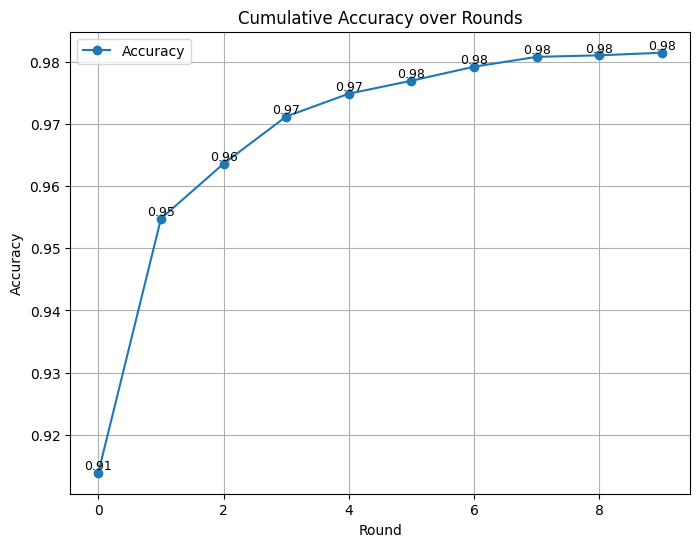

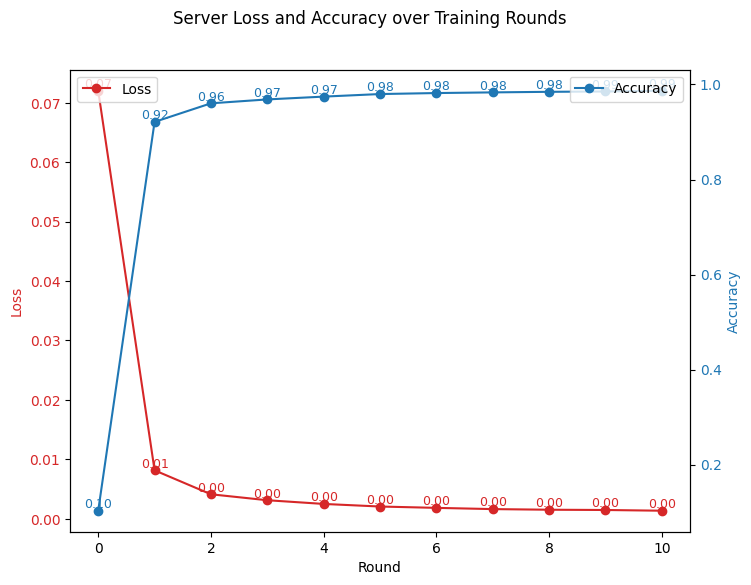

In [49]:
run_my_sim(
    strategy = strategy_3,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)

## FedYogi

In [50]:
strategy_4 = FedYogi(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        eta=0.0001,
        eta_l=0.001,
        tau=1e-8,
        beta_1=0.9,
        beta_2=0.999,
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### RUN


[codecarbon INFO @ 22:10:47] [setup] RAM Tracking...
[codecarbon INFO @ 22:10:47] [setup] GPU Tracking...
[codecarbon INFO @ 22:10:47] No GPU found.
[codecarbon INFO @ 22:10:47] [setup] CPU Tracking...
[codecarbon WARNING @ 22:10:47] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.10508333333333333 


[codecarbon WARNING @ 22:10:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 22:10:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 22:10:49] >>> Tracker's metadata:
[codecarbon INFO @ 22:10:49]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 22:10:49]   Python version: 3.10.12
[codecarbon INFO @ 22:10:49]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 22:10:49]   Available RAM : 12.675 GB
[codecarbon INFO @ 22:10:49]   CPU count: 2
[codecarbon INFO @ 22:10:49]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 22:10:49]   GPU count: None
[codecarbon INFO @ 22:10:49]   GPU model: None
[codecarbon INFO @ 22:10:49] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strateg

FedYogi


INFO :      initial parameters (loss, other metrics): 0.07202895328998565, {'accuracy': 0.1032}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07202895328998565 / accuracy 0.1032


[codecarbon INFO @ 22:11:04] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:11:04] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:04] 0.000197 kWh of electricity used since the beginning.
(pid=25856) 2024-12-08 22:11:05.098506: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=25856) 2024-12-08 22:11:05.142325: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=25856) 2024-12-08 22:11:05.155412: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=25856) 2024-12-08 22:11:07.636438: W ten

(ClientAppActor pid=25859) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:11:34] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:11:34] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:34] 0.000591 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 6, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:11:49] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:11:49] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:11:49] 0.000788 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 8, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:12:04] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:12:04] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:04] 0.000984 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (1, 0.07193334066867828, {'accuracy': 0.1032}, 72.36122710900054)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07193334066867828 / accuracy 0.1032
(ClientAppActor pid=25856) [Client 8] evaluate, config: {}
(ClientAppActor pid=25859) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:12:19] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:12:19] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:19] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=25856) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.0727453257838885 
(ClientAppActor pid=25859) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:12:34] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:12:34] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:34] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 1] evaluate, config: {}
(ClientAppActor pid=25859) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:12:49] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:12:49] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:12:49] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:12:49] 0.001821 g.CO2eq/s mean an estimation of 57.411774048039355 kg.CO2eq/year


(ClientAppActor pid=25856) [Client 9, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:13:04] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:13:04] Energy consumed for all CPUs : 0.001594 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:04] 0.001772 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (2, 0.07180042114257812, {'accuracy': 0.1032}, 136.7031850910007)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07180042114257812 / accuracy 0.1032
(ClientAppActor pid=25856) [Client 1] evaluate, config: {}
(ClientAppActor pid=25859) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:13:19] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:13:19] Energy consumed for all CPUs : 0.001771 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:19] 0.001969 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=25856) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333335 0.07261223181088763 
(ClientAppActor pid=25859) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:13:34] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:13:34] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:34] 0.002166 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 7, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:13:49] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:13:49] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:13:49] 0.002363 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 6, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 9, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:14:04] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:14:04] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:04] 0.002560 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (3, 0.07163578622341156, {'accuracy': 0.1032}, 197.97710409499996)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07163578622341156 / accuracy 0.1032


[codecarbon INFO @ 22:14:19] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:14:19] Energy consumed for all CPUs : 0.002479 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:19] 0.002757 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 1] evaluate, config: {}
(ClientAppActor pid=25856) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25859) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=25859) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333335 0.07244786485036214 
(ClientAppActor pid=25856) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:14:34] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:14:34] Energy consumed for all CPUs : 0.002657 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:34] 0.002954 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 7] evaluate, config: {}
(ClientAppActor pid=25856) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:14:49] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:14:49] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:14:49] 0.003150 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:14:49] 0.001820 g.CO2eq/s mean an estimation of 57.408026283643785 kg.CO2eq/year


(ClientAppActor pid=25856) [Client 5, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 9, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:15:04] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:15:04] Energy consumed for all CPUs : 0.003011 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:04] 0.003347 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (4, 0.07144049129486084, {'accuracy': 0.1032}, 256.1396356760006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07144049129486084 / accuracy 0.1032
(ClientAppActor pid=25859) [Client 0] evaluate, config: {}
(ClientAppActor pid=25859) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:15:19] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:15:19] Energy consumed for all CPUs : 0.003188 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:19] 0.003544 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=25859) [Client 1] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07225317053000133 
(ClientAppActor pid=25859) [Client 1, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:15:34] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:15:34] Energy consumed for all CPUs : 0.003365 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:34] 0.003741 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 4] evaluate, config: {}
(ClientAppActor pid=25859) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:15:49] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:15:49] Energy consumed for all CPUs : 0.003542 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:15:49] 0.003938 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:16:04] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:16:04] Energy consumed for all CPUs : 0.003719 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:04] 0.004135 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (5, 0.07121360991001129, {'accuracy': 0.1032}, 313.46329813300054)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07121360991001129 / accuracy 0.1032
(ClientAppActor pid=25856) [Client 0] evaluate, config: {}
(ClientAppActor pid=25856) [Client 4, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:16:19] Energy consumed for RAM : 0.000436 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:16:19] Energy consumed for all CPUs : 0.003896 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:19] 0.004331 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=25859) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10191666666666664 0.07202746677398682 
(ClientAppActor pid=25859) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:16:34] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:16:34] Energy consumed for all CPUs : 0.004073 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:34] 0.004528 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 8] evaluate, config: {}
(ClientAppActor pid=25856) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:16:49] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:16:49] Energy consumed for all CPUs : 0.004250 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:16:49] 0.004725 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:16:49] 0.001820 g.CO2eq/s mean an estimation of 57.40426855915139 kg.CO2eq/year


(ClientAppActor pid=25859) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:17:04] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:17:04] Energy consumed for all CPUs : 0.004427 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:04] 0.004922 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (6, 0.07095361671447754, {'accuracy': 0.1034}, 373.87968945300054)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07095361671447754 / accuracy 0.1034
(ClientAppActor pid=25856) [Client 2] evaluate, config: {}
(ClientAppActor pid=25856) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:17:19] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:17:19] Energy consumed for all CPUs : 0.004604 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:19] 0.005119 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 9] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=25856) [Client 3] evaluate, config: {} [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10216666666666668 0.07176921133200327 
(ClientAppActor pid=25859) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:17:34] Energy consumed for RAM : 0.000535 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:17:34] Energy consumed for all CPUs : 0.004781 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:34] 0.005316 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 0] evaluate, config: {}
(ClientAppActor pid=25856) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:17:49] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:17:49] Energy consumed for all CPUs : 0.004958 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:17:49] 0.005512 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 6, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:18:04] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:18:04] Energy consumed for all CPUs : 0.005135 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:04] 0.005709 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.07066032345294952, {'accuracy': 0.1049}, 432.2001698660006)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07066032345294952 / accuracy 0.1049
(ClientAppActor pid=25856) [Client 2] evaluate, config: {}
(ClientAppActor pid=25859) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25859) [Client 6] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:18:19] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:18:19] Energy consumed for all CPUs : 0.005312 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:19] 0.005906 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.1035 0.07147819902499516 
(ClientAppActor pid=25856) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:18:34] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:18:34] Energy consumed for all CPUs : 0.005489 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:34] 0.006103 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 3] evaluate, config: {}
(ClientAppActor pid=25856) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:18:49] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:18:49] Energy consumed for all CPUs : 0.005666 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:18:49] 0.006300 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:18:49] 0.001820 g.CO2eq/s mean an estimation of 57.39474424367179 kg.CO2eq/year


(ClientAppActor pid=25856) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25856) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:19:04] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:19:04] Energy consumed for all CPUs : 0.005843 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:04] 0.006497 kWh of electricity used since the beginning.
INFO :      fit progress: (8, 0.07033397285938263, {'accuracy': 0.1103}, 491.03584750900063)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07033397285938263 / accuracy 0.1103
(ClientAppActor pid=25856) [Client 1] evaluate, config: {}
(ClientAppActor pid=25859) [Client 3, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25856) [Client 8] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:19:19] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:19:19] Energy consumed for all CPUs : 0.006020 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:19] 0.006693 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.11041666666666665 0.07115402549505234 
(ClientAppActor pid=25859) [Client 0, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25859) [Client 3] evaluate, config: {}
(ClientAppActor pid=25859) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:19:34] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:19:34] Energy consumed for all CPUs : 0.006197 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:34] 0.006890 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 6, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:19:49] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:19:49] Energy consumed for all CPUs : 0.006375 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:19:49] 0.007087 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 9, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:20:04] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:20:04] Energy consumed for all CPUs : 0.006552 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:04] 0.007284 kWh of electricity used since the beginning.
INFO :      fit progress: (9, 0.06997583661079407, {'accuracy': 0.1252}, 547.6250506660008)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06997583661079407 / accuracy 0.1252
(ClientAppActor pid=25859) [Client 3] evaluate, config: {}
(ClientAppActor pid=25856) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25859) [Client 7] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:20:19] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:20:19] Energy consumed for all CPUs : 0.006729 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:19] 0.007481 kWh of electricity used since the beginning.


(ClientAppActor pid=25859) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.12325 0.07079806792736053 
(ClientAppActor pid=25859) [Client 3, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25856) [Client 8] evaluate, config: {}
(ClientAppActor pid=25859) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:20:34] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:20:34] Energy consumed for all CPUs : 0.006906 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:34] 0.007678 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 9, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=25859) [Client 0, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:20:49] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:20:49] Energy consumed for all CPUs : 0.007083 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:20:49] 0.007874 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:20:49] 0.001820 g.CO2eq/s mean an estimation of 57.40513957566122 kg.CO2eq/year


(ClientAppActor pid=25859) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:21:04] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:21:04] Energy consumed for all CPUs : 0.007260 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:04] 0.008071 kWh of electricity used since the beginning.
INFO :      fit progress: (10, 0.06958630197048188, {'accuracy': 0.1443}, 607.1005242680003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.06958630197048188 / accuracy 0.1443
(ClientAppActor pid=25856) [Client 1] evaluate, config: {}
(ClientAppActor pid=25856) [Client 6, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=25859) [Client 7] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:21:19] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:21:19] Energy consumed for all CPUs : 0.007437 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:19] 0.008268 kWh of electricity used since the beginning.


(ClientAppActor pid=25856) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 622.11s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0727453257838885
INFO :      		round 2: 0.07261223181088763
INFO :      		round 3: 0.07244786485036214
INFO :      		round 4: 0.07225317053000133
INFO :      		round 5: 0.07202746677398682
INFO :      		round 6: 0.07176921133200327
INFO :      		round 7: 0.07147819902499516
INFO :      		round 8: 0.07115402549505234
INFO :      		round 9: 0.07079806792736053
INFO :      		round 10: 0.07041150655349096
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07202895328998565
INFO :      		round 1: 0.07193334066867828
INFO :      		round 2: 0.07180042114257812
INFO :      		round 3: 0.07163578622341156
INFO :      		round 4: 0.07144049129486084
INFO :      		round 5: 0.07121360991001129
INFO :      		round 6: 0.07095361671447754
INFO :      		round 7: 0.0706603234

My_weighted_average -0.1443333333333333 0.07041150655349096 
(ClientAppActor pid=25859) [Client 2] evaluate, config: {}


(ClientAppActor pid=25859) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=25859) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=25859) see the appropriate new directories, set the environment variable
(ClientAppActor pid=25859) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=25859) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=25859)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
[codecarbon INFO @ 22:21:23] Energy consumed for RAM : 0.000837 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:21:23] Energy consumed for all CPUs : 0.007487 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:23] 0.008324 kWh of electricity used since the beginning.


Emissions: 0.0011549382853992185 kg CO2e
Model saved to FedYogi/net_weights.pth
Aggregation history saved to FedYogi/Aggregation_history.pkl
Evaluation history saved to FedYogi/evaluation_history.pkl
Emissions data saved to FedYogi/emissions.txt


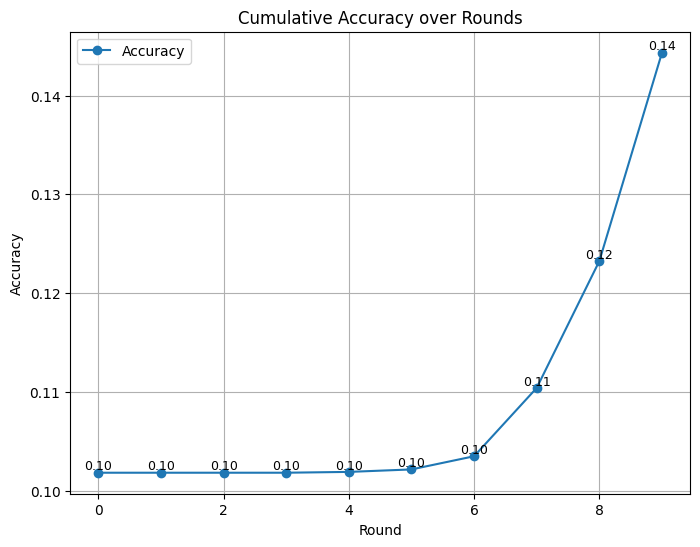

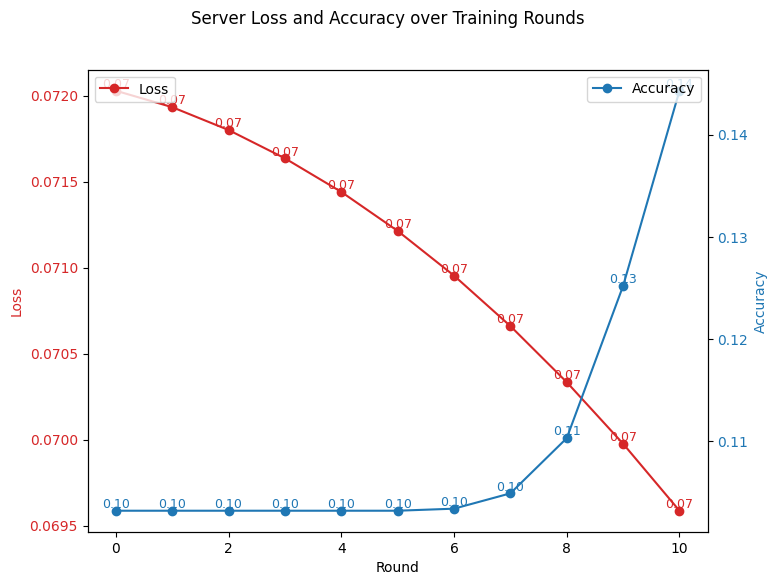

In [51]:
run_my_sim(
    strategy = strategy_4,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)

## FedAdam

In [52]:
strategy_5 = FedAdam(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        eta=0.0001,
        eta_l=0.001,
        beta_1=0.9,
        beta_2=0.999,
        tau=1e-8,
    )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### RUN


[codecarbon INFO @ 22:21:31] [setup] RAM Tracking...
[codecarbon INFO @ 22:21:31] [setup] GPU Tracking...
[codecarbon INFO @ 22:21:31] No GPU found.
[codecarbon INFO @ 22:21:31] [setup] CPU Tracking...
[codecarbon WARNING @ 22:21:31] No CPU tracking mode found. Falling back on CPU constant mode. 
 Linux OS detected: Please ensure RAPL files exist at \sys\class\powercap\intel-rapl to measure CPU



model is reset.. dont beleve me?.. acc= 0.096 


[codecarbon WARNING @ 22:21:32] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 22:21:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 22:21:32] >>> Tracker's metadata:
[codecarbon INFO @ 22:21:32]   Platform system: Linux-6.1.85+-x86_64-with-glibc2.35
[codecarbon INFO @ 22:21:32]   Python version: 3.10.12
[codecarbon INFO @ 22:21:32]   CodeCarbon version: 2.8.1
[codecarbon INFO @ 22:21:32]   Available RAM : 12.675 GB
[codecarbon INFO @ 22:21:32]   CPU count: 2
[codecarbon INFO @ 22:21:32]   CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon INFO @ 22:21:32]   GPU count: None
[codecarbon INFO @ 22:21:32]   GPU model: None
[codecarbon INFO @ 22:21:33] Saving emissions data to file /content/emissions.csv
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strateg

FedAdam


INFO :      initial parameters (loss, other metrics): 0.07202895328998565, {'accuracy': 0.1032}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07202895328998565 / accuracy 0.1032


[codecarbon INFO @ 22:21:48] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:21:48] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:21:48] 0.000197 kWh of electricity used since the beginning.
(pid=30562) 2024-12-08 22:21:49.412169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=30563) 2024-12-08 22:21:49.423134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=30563) 2024-12-08 22:21:49.435451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=30563) 2024-12-08 22:21:51.891513: W ten

(ClientAppActor pid=30562) [Client 2, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:22:18] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:22:18] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:18] 0.000591 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 5, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30563) [Client 9, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:22:33] Energy consumed for RAM : 0.000079 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:22:33] Energy consumed for all CPUs : 0.000708 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:33] 0.000787 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 4, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30563) [Client 0, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:22:48] Energy consumed for RAM : 0.000099 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:22:48] Energy consumed for all CPUs : 0.000885 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:22:48] 0.000984 kWh of electricity used since the beginning.
INFO :      fit progress: (1, 0.07200673289299012, {'accuracy': 0.1032}, 69.99381876899952)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07200673289299012 / accuracy 0.1032
(ClientAppActor pid=30563) [Client 2] evaluate, config: {}
(ClientAppActor pid=30562) [Client 3, round 1] fit, config: {'server_round': 1, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30563) [Client 7] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:23:03] Energy consumed for RAM : 0.000119 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:23:03] Energy consumed for all CPUs : 0.001062 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:03] 0.001181 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07281884489456814 
(ClientAppActor pid=30563) [Client 3, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:23:18] Energy consumed for RAM : 0.000139 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:23:18] Energy consumed for all CPUs : 0.001239 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:18] 0.001378 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 7, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:23:33] Energy consumed for RAM : 0.000158 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:23:33] Energy consumed for all CPUs : 0.001416 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:33] 0.001575 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:23:33] 0.001821 g.CO2eq/s mean an estimation of 57.41167197160606 kg.CO2eq/year


(ClientAppActor pid=30562) [Client 6, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:23:48] Energy consumed for RAM : 0.000178 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:23:48] Energy consumed for all CPUs : 0.001593 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:23:48] 0.001772 kWh of electricity used since the beginning.
INFO :      fit progress: (2, 0.07198127071857452, {'accuracy': 0.1032}, 129.68642882099994)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07198127071857452 / accuracy 0.1032
(ClientAppActor pid=30562) [Client 2] evaluate, config: {}
(ClientAppActor pid=30563) [Client 4, round 2] fit, config: {'server_round': 2, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30562) [Client 7] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:24:03] Energy consumed for RAM : 0.000198 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:24:03] Energy consumed for all CPUs : 0.001770 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:03] 0.001968 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 3] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07279338856538138 
(ClientAppActor pid=30562) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:24:18] Energy consumed for RAM : 0.000218 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:24:18] Energy consumed for all CPUs : 0.001948 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:18] 0.002165 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 5] evaluate, config: {}
(ClientAppActor pid=30562) [Client 3, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 2, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:24:33] Energy consumed for RAM : 0.000238 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:24:33] Energy consumed for all CPUs : 0.002125 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:33] 0.002362 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 4, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:24:48] Energy consumed for RAM : 0.000257 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:24:48] Energy consumed for all CPUs : 0.002302 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:24:48] 0.002559 kWh of electricity used since the beginning.
INFO :      fit progress: (3, 0.0719540245294571, {'accuracy': 0.1032}, 188.39916949399958)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0719540245294571 / accuracy 0.1032
(ClientAppActor pid=30562) [Client 2] evaluate, config: {}
(ClientAppActor pid=30563) [Client 5, round 3] fit, config: {'server_round': 3, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30563) [Client 7] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:25:03] Energy consumed for RAM : 0.000277 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:25:03] Energy consumed for all CPUs : 0.002478 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:03] 0.002756 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.0727661255200704 
(ClientAppActor pid=30562) [Client 0, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30562) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:25:18] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:25:18] Energy consumed for all CPUs : 0.002656 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:18] 0.002952 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 8, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:25:33] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:25:33] Energy consumed for all CPUs : 0.002833 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:33] 0.003149 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:25:33] 0.001820 g.CO2eq/s mean an estimation of 57.40401652669585 kg.CO2eq/year


(ClientAppActor pid=30562) [Client 7, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:25:48] Energy consumed for RAM : 0.000336 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:25:48] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:25:48] 0.003346 kWh of electricity used since the beginning.
INFO :      fit progress: (4, 0.07192572872638703, {'accuracy': 0.1032}, 249.1045653709998)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07192572872638703 / accuracy 0.1032
(ClientAppActor pid=30563) [Client 2] evaluate, config: {}
(ClientAppActor pid=30563) [Client 3, round 4] fit, config: {'server_round': 4, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30563) [Client 8] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:26:03] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:26:03] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:03] 0.003543 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07273775873581567 
(ClientAppActor pid=30562) [Client 0, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30562) [Client 0] evaluate, config: {}
(ClientAppActor pid=30562) [Client 3, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:26:18] Energy consumed for RAM : 0.000376 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:26:18] Energy consumed for all CPUs : 0.003364 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:18] 0.003740 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 2, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:26:33] Energy consumed for RAM : 0.000396 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:26:33] Energy consumed for all CPUs : 0.003541 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:33] 0.003937 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 8, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:26:48] Energy consumed for RAM : 0.000416 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:26:48] Energy consumed for all CPUs : 0.003718 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:26:48] 0.004133 kWh of electricity used since the beginning.
INFO :      fit progress: (5, 0.07189655346870423, {'accuracy': 0.1032}, 307.39679932299987)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07189655346870423 / accuracy 0.1032
(ClientAppActor pid=30563) [Client 1] evaluate, config: {}
(ClientAppActor pid=30563) [Client 7, round 5] fit, config: {'server_round': 5, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30563) [Client 7] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:27:03] Energy consumed for RAM : 0.000435 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:27:03] Energy consumed for all CPUs : 0.003895 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:03] 0.004330 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07270850972334543 
(ClientAppActor pid=30562) [Client 0, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30562) [Client 5, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:27:18] Energy consumed for RAM : 0.000455 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:27:18] Energy consumed for all CPUs : 0.004072 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:18] 0.004527 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30563) [Client 7, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:27:33] Energy consumed for RAM : 0.000475 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:27:33] Energy consumed for all CPUs : 0.004249 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:33] 0.004724 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:27:33] 0.001820 g.CO2eq/s mean an estimation of 57.40670929102423 kg.CO2eq/year


(ClientAppActor pid=30563) [Client 3, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:27:48] Energy consumed for RAM : 0.000495 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:27:48] Energy consumed for all CPUs : 0.004426 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:27:48] 0.004920 kWh of electricity used since the beginning.
INFO :      fit progress: (6, 0.07186669530868531, {'accuracy': 0.1032}, 369.53045014500003)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07186669530868531 / accuracy 0.1032
(ClientAppActor pid=30563) [Client 3] evaluate, config: {}
(ClientAppActor pid=30562) [Client 2, round 6] fit, config: {'server_round': 6, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30563) [Client 8] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:28:03] Energy consumed for RAM : 0.000515 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:28:03] Energy consumed for all CPUs : 0.004603 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:03] 0.005117 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333332 0.07267861880858739 
(ClientAppActor pid=30563) [Client 3, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:28:18] Energy consumed for RAM : 0.000534 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:28:18] Energy consumed for all CPUs : 0.004780 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:18] 0.005314 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 4] evaluate, config: {}
(ClientAppActor pid=30563) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30563) [Client 7, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:28:33] Energy consumed for RAM : 0.000554 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:28:33] Energy consumed for all CPUs : 0.004957 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:33] 0.005511 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 2, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30563) [Client 0, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:28:48] Energy consumed for RAM : 0.000574 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:28:48] Energy consumed for all CPUs : 0.005134 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:28:48] 0.005708 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (7, 0.07183623757362366, {'accuracy': 0.1032}, 430.5980809269995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07183623757362366 / accuracy 0.1032
(ClientAppActor pid=30562) [Client 2] evaluate, config: {}
(ClientAppActor pid=30562) [Client 8, round 7] fit, config: {'server_round': 7, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30563) [Client 7] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:29:03] Energy consumed for RAM : 0.000594 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:29:03] Energy consumed for all CPUs : 0.005311 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:03] 0.005905 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 4] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333335 0.07264816560347875 
(ClientAppActor pid=30562) [Client 0, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:29:18] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:29:18] Energy consumed for all CPUs : 0.005488 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:18] 0.006102 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 1] evaluate, config: {}
(ClientAppActor pid=30562) [Client 2, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 6, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:29:33] Energy consumed for RAM : 0.000633 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:29:33] Energy consumed for all CPUs : 0.005665 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:33] 0.006298 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:29:33] 0.001820 g.CO2eq/s mean an estimation of 57.405957717726324 kg.CO2eq/year


(ClientAppActor pid=30562) [Client 5, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 9, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:29:48] Energy consumed for RAM : 0.000653 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:29:48] Energy consumed for all CPUs : 0.005842 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:29:48] 0.006495 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (8, 0.07180517973899841, {'accuracy': 0.1032}, 491.5026714979995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07180517973899841 / accuracy 0.1032
(ClientAppActor pid=30562) [Client 1] evaluate, config: {}
(ClientAppActor pid=30563) [Client 8, round 8] fit, config: {'server_round': 8, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:30:03] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:30:03] Energy consumed for all CPUs : 0.006019 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:03] 0.006692 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=30562) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333333 0.07261709078152975 
(ClientAppActor pid=30562) [Client 2, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:30:18] Energy consumed for RAM : 0.000693 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:30:18] Energy consumed for all CPUs : 0.006196 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:18] 0.006889 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 9] evaluate, config: {}
(ClientAppActor pid=30562) [Client 3, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 5, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:30:33] Energy consumed for RAM : 0.000713 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:30:33] Energy consumed for all CPUs : 0.006373 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:33] 0.007086 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 1, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 7, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:30:48] Energy consumed for RAM : 0.000732 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:30:48] Energy consumed for all CPUs : 0.006550 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:30:48] 0.007283 kWh of electricity used since the beginning.
INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      fit progress: (9, 0.0717736099243164, {'accuracy': 0.1032}, 550.6286634399994)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.0717736099243164 / accuracy 0.1032
(ClientAppActor pid=30562) [Client 2] evaluate, config: {}
(ClientAppActor pid=30563) [Client 8, round 9] fit, config: {'server_round': 9, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30562) [Client 6] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:31:03] Energy consumed for RAM : 0.000752 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:31:03] Energy consumed for all CPUs : 0.006727 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:03] 0.007479 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 7] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


My_weighted_average -0.10183333333333335 0.07258552575111389 
(ClientAppActor pid=30562) [Client 4, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}


[codecarbon INFO @ 22:31:18] Energy consumed for RAM : 0.000772 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:31:18] Energy consumed for all CPUs : 0.006905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:18] 0.007676 kWh of electricity used since the beginning.


(ClientAppActor pid=30563) [Client 4] evaluate, config: {}
(ClientAppActor pid=30562) [Client 5, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 7, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]
(ClientAppActor pid=30562) [Client 2, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


[codecarbon INFO @ 22:31:33] Energy consumed for RAM : 0.000792 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:31:33] Energy consumed for all CPUs : 0.007082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:33] 0.007873 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:31:33] 0.001820 g.CO2eq/s mean an estimation of 57.409947214069994 kg.CO2eq/year


(ClientAppActor pid=30562) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01} [repeated 2x across cluster]


INFO :      aggregate_fit: received 10 results and 0 failures
[codecarbon INFO @ 22:31:48] Energy consumed for RAM : 0.000812 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:31:48] Energy consumed for all CPUs : 0.007259 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:31:48] 0.008070 kWh of electricity used since the beginning.
INFO :      fit progress: (10, 0.07174140493869781, {'accuracy': 0.1032}, 608.1338209919995)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Server-side evaluation loss 0.07174140493869781 / accuracy 0.1032
(ClientAppActor pid=30562) [Client 1] evaluate, config: {}
(ClientAppActor pid=30563) [Client 8, round 10] fit, config: {'server_round': 10, 'local_epochs': 1, 'learning rate': 0.01}
(ClientAppActor pid=30563) [Client 6] evaluate, config: {} [repeated 4x across cluster]


[codecarbon INFO @ 22:32:03] Energy consumed for RAM : 0.000831 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:32:03] Energy consumed for all CPUs : 0.007436 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:03] 0.008267 kWh of electricity used since the beginning.


(ClientAppActor pid=30562) [Client 3] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 623.54s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07281884489456814
INFO :      		round 2: 0.07279338856538138
INFO :      		round 3: 0.0727661255200704
INFO :      		round 4: 0.07273775873581567
INFO :      		round 5: 0.07270850972334543
INFO :      		round 6: 0.07267861880858739
INFO :      		round 7: 0.07264816560347875
INFO :      		round 8: 0.07261709078152975
INFO :      		round 9: 0.07258552575111389
INFO :      		round 10: 0.07255334375301996
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07202895328998565
INFO :      		round 1: 0.07200673289299012
INFO :      		round 2: 0.07198127071857452
INFO :      		round 3: 0.0719540245294571
INFO :      		round 4: 0.07192572872638703
INFO :      		round 5: 0.07189655346870423
INFO :      		round 6: 0.07186669530868531
INFO :      		round 7: 0.07183623757

My_weighted_average -0.10183333333333333 0.07255334375301996 
(ClientAppActor pid=30563) [Client 4] evaluate, config: {}


(ClientAppActor pid=30563) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=30563) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=30563) see the appropriate new directories, set the environment variable
(ClientAppActor pid=30563) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=30563) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=30563)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
[codecarbon INFO @ 22:32:09] Energy consumed for RAM : 0.000840 kWh. RAM Power : 4.7530388832092285 W
[codecarbon INFO @ 22:32:09] Energy consumed for all CPUs : 0.007514 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 22:32:09] 0.008354 kWh of electricity used since the beginning.


Emissions: 0.0011591695862265678 kg CO2e
Model saved to FedAdam/net_weights.pth
Aggregation history saved to FedAdam/Aggregation_history.pkl
Evaluation history saved to FedAdam/evaluation_history.pkl
Emissions data saved to FedAdam/emissions.txt


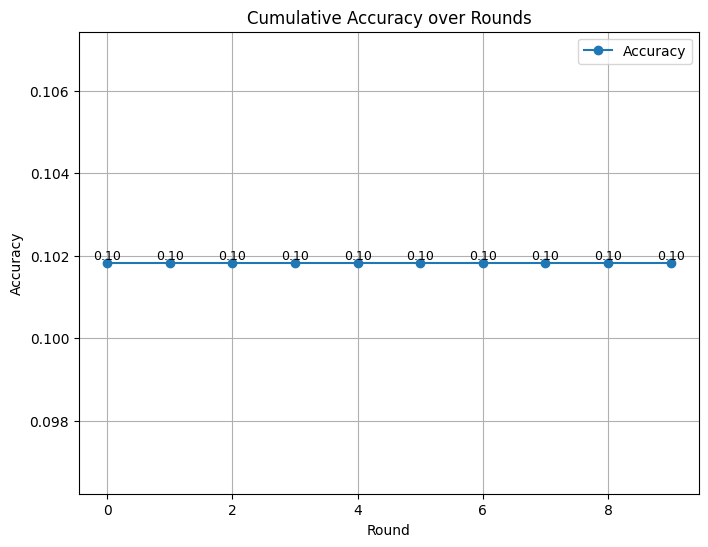

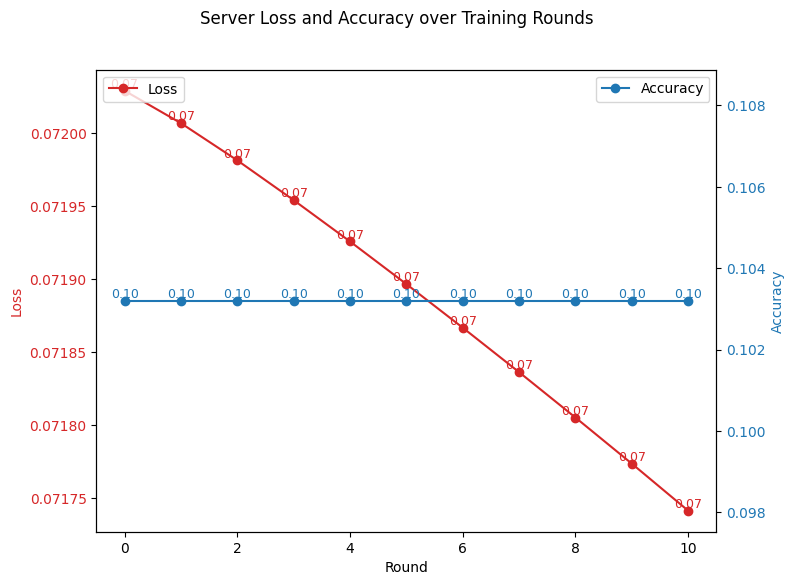

In [53]:
run_my_sim(
    strategy = strategy_5,
    num_rounds = Num_rounds,
    num_clients = NUM_CLIENTS,
)